# <div style="text-align: center">------------------Projet 9------------------- </div>
# <div style="text-align: center"> -------Produire une Etude de Marché---- </div>
# <div style="text-align: center"> ------Data Visualisation des Clusters </div>

![logo](logo.png)

Auteur: Lauren GUIOT

Date: 07/04/2023

## introduction
<br>
<div style="text-align: justify">Notre entreprise, spécialisée dans l’agroalimentaire, envisage d’étendre l’exportation de sa production de poulet à l’international. 
Le choix de pays étant vaste, Patrick m’a demandé d’analyser et sélectionner des groupes de pays ayant le plus fort potentiel de développement. <br>
    <br>
Le service pourra alors cibler et approfondir l’étude de marché sur les pays sélectionnés.  </div>

#### Ce book présentera la méthode de clustering ainsi que l'analyse de ces différents clusters.

Objectif du projet:
* Effectuer un clustering simple
* Explorer des données pour synthétiser des variables


# Sommaire <a class="anchor" id="sommaire"></a>
* [I.Préparation pour le clustering](#I)


* [II. Partionner les donnéess](#II)
    * [a. Classification ascendante Hierarchique](#II.a)
        * [Création du Dendogramme](#II.a.1)
        * [Réduction du nombre de clusters](#II.a.2)
    * [b. K-means](#II.b)
        * [Déterminer le nombre de clusters](#II.b.1)
        * [Appliquer le Kmeans](#II.b.2)


* [III. Analyse des clustering](#III)
    * [a.Comparaison des clusters](#III.a)
        * [Clusters de la classification ascendante Hierarchique](#III.a.1)
        * [Clusters du Kmeans](#III.a.2)
    * [b.Visualision des clusters](#III.b)
        * [sur une projection des individus avec toutes les variables](#III.b.1)
        * [sur projection des individus sur les 4 premières dimensions](#III.b.2)
        * [application et visualisation Kmeans sur les groupes 0 et 1 du Kmeans](#III.b.3)
        * [suivant la Dispersion de leurs variables](#III.b.4)
        * [sur une carte du monde](#III.b.5)
    
* [Conclusion/ Recommandations](#conclu)

<h2 style="text-align: center; text-decoration:bold; margin: auto; padding: 5px; color:#36151D;">I. Préparation </h2>
<a class="anchor" id="I"></a>

In [1]:
# Importation des différentes Librairies

import numpy as np                                           # v1.19.2
import pandas as pd                                          # v1.2.5

                                                             # scipy v1.7.3
from scipy.cluster.hierarchy import linkage, fcluster         # Classification Hierarchique
from scipy.cluster.hierarchy import dendrogram                # Dendogram
from scipy.spatial.distance import cdist                      # Methode du coude

                                                             # sklearn v0.23.2
from sklearn import decomposition                             # ACP
from sklearn.preprocessing import StandardScaler             # Centré-Réduire
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans                            # K-means
from sklearn.ensemble import IsolationForest


import seaborn as sns  ; sns.set()                           # v 0.11.0 
import matplotlib.pyplot as plt                              # v 3.3.2


# Module a installer
from yellowbrick.cluster import KElbowVisualizer             # v 1.4 Methode coude
from yellowbrick.cluster import SilhouetteVisualizer
import geopandas                                        # Graphique 

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer


In [2]:
# Customiser la présentation des polices
class P:
    H = '\033[95m'  #Header
    BL = '\033[94m'  # Bleu
    G = '\033[92m' # Vert
    R = '\033[93m' #Rouge
    E = '\033[0m' # End
    B = '\033[1m' #Bold
    U = '\033[4m' # Underline

# Visualiser les valeurs uniques de chaque variable    
def valunique(table) :
    for i in table : 
        unique= table[i].unique()
        if len(unique) < 50 :
            print(P.U + i +P.E,len(unique),"valeurs différentes""\n", unique, "\n" )
        else :
            print(P.U + i +P.E,len(unique),"valeurs différentes" "\n" )
            
# exploration des données (doublon NaN, uniques, structure, etc.)            
def exploration(table):
    table.describe(include='all')
    vnames = [name for name in globals() if globals()[name] is table]
    print(P.H +P.U + (f'ANALYSE STRUCTURE de la table {vnames}')+ P.E)
    print(P.B + P.G+f" Taille:{table.shape}"+P.E)
    print('\n', P.B+ P.G+ 'Types de variable: '+ P.E)
    print(table.info())
    print(P.B+ P.G+ '\nDonnées Uniques: ' +P.E)
    print(valunique(table))
    print(P.B+ P.G+ '\nAnalyse Doublons: ' +P.E)
    print(table.duplicated().sum())
    print(P.B + P.G+ '\nDonnées Manquantes: ' +P.E)
    print(table.isna().mean())
    print(sns.heatmap(table==0.0, cbar=False))
    print(P.B+ P.G+ '\nAnalyse Globales & Heat map des valeurs manquantes: ' +P.E)
    
# exploration descriptive des tables
def explo(table):
    return table.describe(include='all')


# Cercle de corrélation
def correlation_graph(pca, x_y, features) :   
    x,y=x_y

    fig, ax = plt.subplots(figsize=(10, 10))

    #Création du graphique
    for i in range(0, pcs.shape[1]):
        ax.arrow(0,0, pcs[x, i], pcs[y, i],head_width=0.03,
                head_length=0.03, color='red', width=0.01, )

        plt.text(pcs[x,i]+0.02, pcs[y,i]+0, features[i], fontsize=14)
        
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(scree[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(scree[y],1)))
    
    plt.title("Cercle des corrélations (F{} et F{}) à {}%".format(x+1, y+1, (round(scree[x]+scree[y], 2))))
    
    # Le cercle 
    plt.gca().add_artist(plt.Circle((0,0), 1, facecolor='none', edgecolor='purple'))


    # Axes et display
    plt.axis('equal')
    plt.show(block=False)
    
# Projection des individus
def display_factorial_planes( PCA, label1, label2, x, y, echel1, echel2,clusters=None, centroid= None, figsize=(15,15) ):

    ces = (15,15) if figsize is None else figsize    
    fig, ax = plt.subplots(1,1, figsize=ces)

    c = None if clusters is None else clusters
    ce= None if centroid is None else plt.scatter(centroids_projected[:,x],centroids_projected[:,y], s=200, 
                                                  marker= 's', c='green', alpha=0.3, label='centroids', cmap= 'jet') 

    
    #Nuage de Points
    sns.scatterplot(data=None, x=PCA[label1], y=PCA[label2], hue=c, palette="deep", style=c)
    
    
    # Affichage des pays
    for k in PCA.iterrows():
        if (abs(k[1][label1]) > echel1) | (abs(k[1][label2]) > echel2):
            ax.annotate(k[1]["Country"], (k[1][label1], k[1][label2]), fontsize = 15)

    # Variance
    v1 = str(round(scree[x]))  + " %"
    v2 = str(round(scree[y]))  + " %"
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')
    
    # Bornage            ====================> Même echelle 
    x_max = abs(PCA[label1].max()) *1.1
    y_max = abs(PCA[label2].max()) *1.1
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)
    plt.plot([-x_max, x_max], [0,0], color='silver', ls='--', linewidth=1)
    plt.plot( [0,0], [-y_max, y_max], color='grey', ls='--', linewidth=1)
    plt.title(f"Projection des {PCA.shape[0]} individus sur le {x+1}e et {y+1}eme plan factoriel")
    plt.grid(color='white')
    plt.show()     

In [3]:
# pour avoir les données qualitatives
etuds = pd.read_csv("etudQLT.csv") 

# Pour avoir seulement les données quantitatives pour le clustering
etud= pd.read_csv("etudQTT.csv")    

# Pour avoir les donnnées projetées
PCA_indiv = pd.read_csv("PCA_indiv.csv")

# Pour avoir les données Latitudes/longitudes pour situer les pays
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres')) # pour avoir les coordonnées de chaque pays
pd.set_option('display.max_columns', None)

In [4]:
# Remplacer le nom des pays anglais pour pouvoir correspondre avec la table etuds pour la Map Monde
dict_countries = {"Bosnia and Herz.":"Bosnia and Herzegovina", "Central African Rep.": "Central African Republic",
                  "Czechia":"Czech Republic","North Korea":"Korea, Dem. People's Rep. of",
                  "Dem. Rep. Congo":"Democratic Republic of the Congo","Dominican Rep.":" Dominican Republic",
                  "eSwatini":"Eswatini", "Kazakhstan":"Kazakstan","Laos": "Lao People's Democratic Republic",
                  "Serbia": "Serbia and Montenegro","Myanmar":"Burma","North Macedonia":"Macedonia (the former Yugoslav Rep. of)",
                  "South Korea":"Korea", "Moldova":"Moldova, Rep.of","Russia":"Russian Federation", 
                  "Solomon Is.":"Solomon Islands","S. Sudan":"South Sudan","Syria":"Syrian Arab Republic",
                  "Timor-Leste":"East Timor","Tanzania": "Tanzania, United Rep. of ","Vietnam":"Viet Nam"} 
world = world.replace({"name":dict_countries})

In [5]:
# affecter les valeurs dans différentes variables.
nbIndiv=len(etud)
nbVariables=len(etud.columns)-1

data=etud.set_index("Area")
X= data.values           # Stockage des valeurs

names= data.index        # stockage du nom des Individus (pays)

features=data.columns    # Stockage du nom des variables 

X_projected = PCA_indiv.drop(columns='Country')    # Coordonnées des individus Projetées sans réduction de dimensions

In [6]:
## CENTRAGE REDUCTION DES DONNEES CAR LES ECHELLES DE MESURES SONT HETEROGENES

#  MinMax
X_scaled = MinMaxScaler().fit_transform(X)

Data_scaled=pd.DataFrame(X_scaled, index=names, columns=etud.drop(columns='Area').columns)

#Projection des données avec les 4 premières dimensions
n_comp= 4 # Nombre composants 
pca=decomposition.PCA(n_components=n_comp)
pca.fit_transform(X_scaled)
scree= pca.explained_variance_ratio_*100

idx = ["mean", "std", "min", "max"]
pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

,0,1,2,3,4,5,6,7,8,9
mean,0.10,0.32,0.22,0.46,0.25,0.02,0.67,0.14,0.62,0.67
std,0.17,0.25,0.22,0.25,0.20,0.09,0.19,0.19,0.22,0.21
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


* [sommaire](#sommaire)

<div>
    <a class="anchor" id="II"></a>
<h2 style="text-align: center; text-decoration:bold; margin: auto; padding: 5px; color:#36151D;">II) Partionner les données</h2>
</div>


<div style="background-color: #F56086;">
    <a class="anchor" id="II.a"></a>
<h2 style="text-align: center; text-decoration:bold; margin: auto; padding: 5px; color:#36151D;"> a. Classification ascendante Hierarchique<a class="anchor" id="II.a"></a>

<a class="anchor" id="II.a.1"></a>
<h2 style="text-align: center;text-decoration:bold;color:#736767;background-color:#F2DAEF">Création du Dendrogramme</h2>




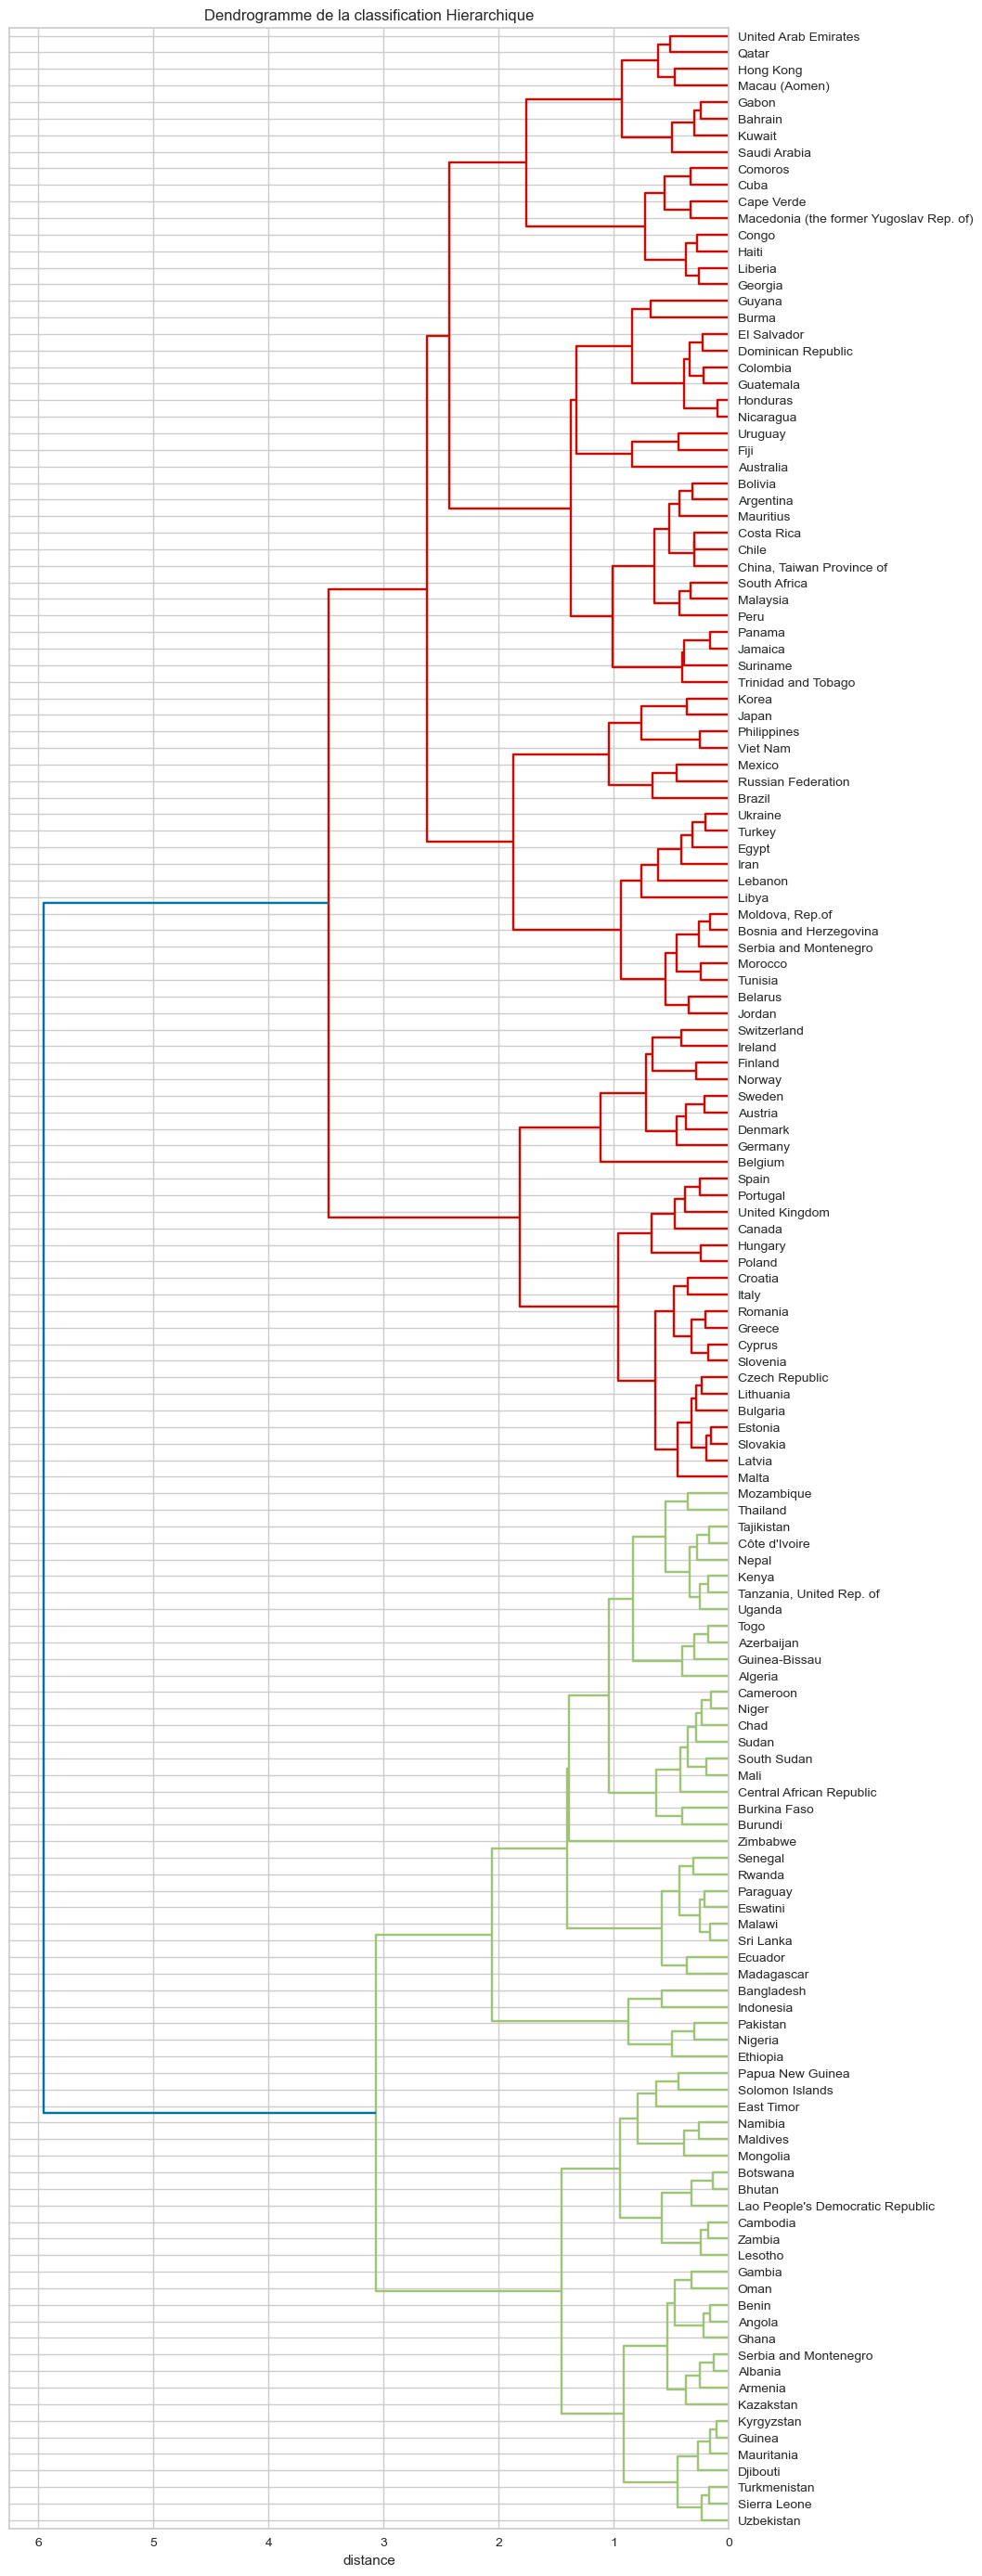

In [7]:
# CLASSIFICATION AH

Z = linkage(X_scaled, method='ward', metric="euclidean", optimal_ordering=True)   # Méthode Ward
# Création du graphique Dendrogramme
plt.figure(figsize=(10,35))
plt.title('Dendrogramme de la classification Hierarchique')
plt.xlabel('distance')
dendrogram(Z, labels=names,leaf_font_size=10, orientation= 'left', distance_sort="ascending") 

plt.show()

Visuellement nous remarquons soit 2, 3, 4 ou 6 groupes de pays suivant la distance où nous coupons le dendrogramme.

* [sommaire](#sommaire)

<a class="anchor" id="II.a.2"></a>
<h2 style="text-align: center;text-decoration:bold;color:#736767;background-color:#F2DAEF">Réduction du nombre de clusters</h2>




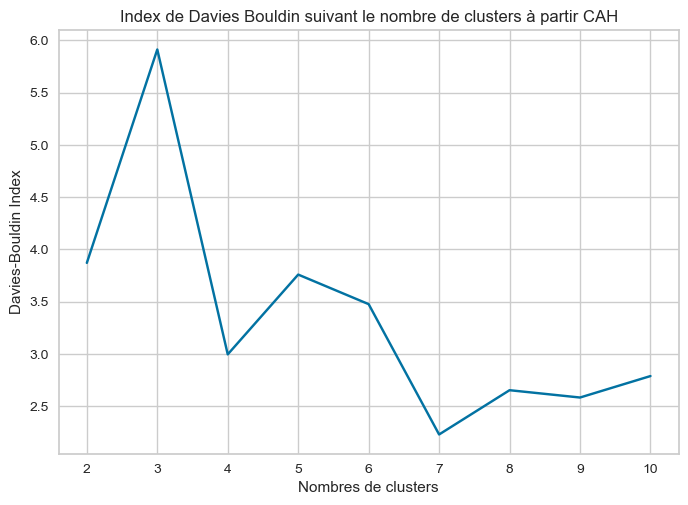

In [8]:
results = {}

for i in range(2,nbVariables+1):
    clusters = fcluster(Z, i, criterion='maxclust') # application du CAH pour chaque cluster
    db = davies_bouldin_score(X, clusters) # application de l'index 
    results.update({i: db})

plt.plot(list(results.keys()), list(results.values()))
plt.xlabel("Nombres de clusters")
plt.ylabel("Davies-Bouldin Index")
plt.title("Index de Davies Bouldin suivant le nombre de clusters à partir CAH")
plt.show()

en appliquant l'indice de Davies Bouldin, le nombre de cluster idéal serait 7. Je vais donc découper mes pays en 7 groupes distincts.

In [9]:
Clusters = fcluster(Z, 7, criterion='maxclust')  # 7 clusters 
CCAH=pd.DataFrame({'cluster':Clusters, "names":names})
CCAH.groupby("cluster").count()


,names
cluster,
1,30
2,5
3,28
4,24
5,16
6,20
7,28


In [10]:
CCAH[CCAH.cluster==2]

,cluster,names
9,2,Bangladesh
48,2,Ethiopia
64,2,Indonesia
100,2,Nigeria
104,2,Pakistan


La répartition de pays est homogène hormis au niveau du cluster 2 qui possède seulement 5 pays.

In [11]:
# Rajout de la classe dans une colonne 
Dend_classe = etuds.assign(classe=Clusters)
Dend_classe1= round(Dend_classe.groupby("classe").mean(),6)
Dendo_classe= Data_scaled.assign(classe=Clusters ) # données scaled
Dendo_classe1= Dendo_classe.groupby("classe").mean() # données brutes

* [sommaire](#sommaire)

<div style="background-color: #F56086;">
    <a class="anchor" id="II.b"></a>
<h2 style="text-align: center; text-decoration:bold; margin: auto; padding: 5px; color:#36151D;"> b. K-means<a class="anchor" id="II.b"></a>


<a class="anchor" id="II.b.1"></a>
<h2 style="text-align: center;text-decoration:bold;color:#736767;background-color:#F2DAEF">Déterminer le nombre de clusters</h2>




In [12]:
## KMEANS 

inertie=[]  
distortions=[]
Intergroup=[]

for i in range(1,nbVariables+1):
    # application du kmean pour 1 à n clusters
    km=KMeans(n_clusters=i, random_state=8)
    y_km=km.fit_predict(X_scaled)
    # Calcul de l'inertie (intra groupe)qui est la somme au carré des échantillons par rapport à leur centre de cluster le plus proche
    inertie.append(km.inertia_)
    # Calcul de la distortion qui est la moyenne des distances au carré des centres respectifs.
    distortions.append(sum(np.min(cdist(X_scaled, km.cluster_centers_, 'euclidean'),axis=1)) / X_scaled.shape[0]) 
    # Calcul de l'inertie Inter groupe qui est la somme au carré des centroids soustrait par la moyenne générale
    Intergroup.append(((km.cluster_centers_[y_km]-X_scaled.mean())**2.0).sum(axis=1).sum())
    
R2=pd.DataFrame({'interclasse': Intergroup, 'intraclasse':inertie, 'Distortion':distortions})
R2["Inertie totale"]= R2.intraclasse+ R2.interclasse
R2["R2"]= R2.interclasse/ R2.intraclasse
R2   

,interclasse,intraclasse,Distortion,Inertie totale,R2
0,81.136261,62.430559,0.614511,143.56682,1.299624
1,99.750298,43.816522,0.510123,143.56682,2.276545
2,106.595680,36.971140,0.464674,143.56682,2.883213
3,111.400906,32.165914,0.434925,143.56682,3.463322
4,114.840315,28.726505,0.410523,143.56682,3.997713
5,116.912734,26.654086,0.396655,143.56682,4.386297
6,118.770453,24.796367,0.381221,143.56682,4.789833
7,120.418960,23.147860,0.371644,143.56682,5.202164
8,122.148684,21.418136,0.353151,143.56682,5.703049
9,123.008405,20.558415,0.345143,143.56682,5.983360


### Méthode de la Silhouette

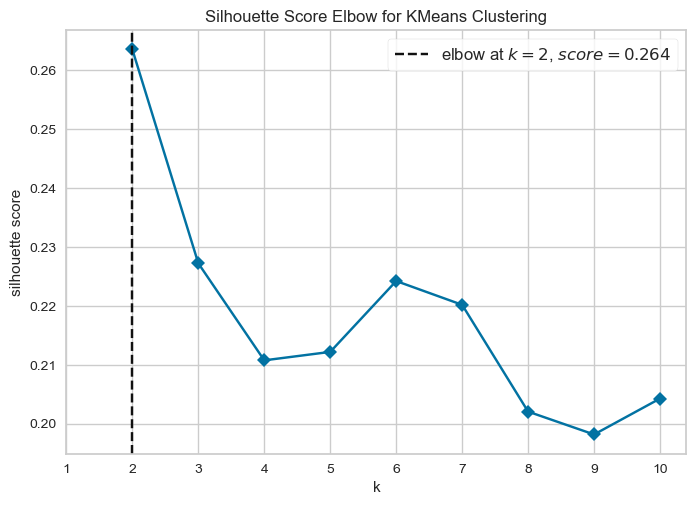

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [13]:
km = KMeans(random_state=8)
visualizer= KElbowVisualizer(km, k=(2,nbVariables+1), metric='silhouette', timings=False)
visualizer.fit(X_scaled)

plt.xticks(range(1,nbVariables+1))
visualizer.show()

### Méthode du coude

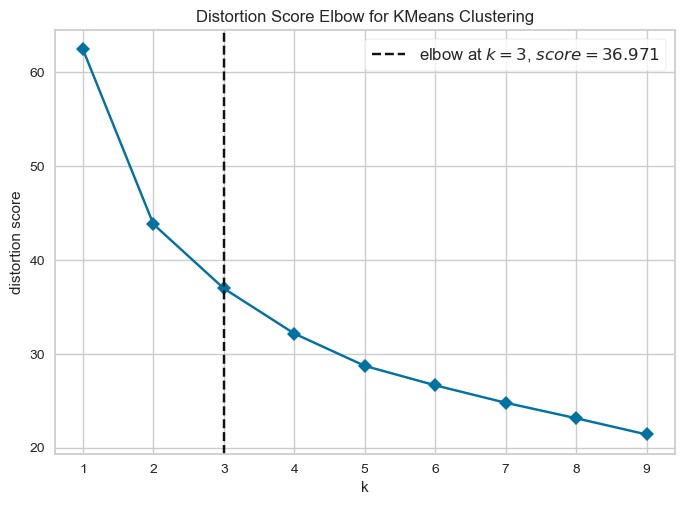

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [14]:
km = KMeans(random_state=8)
visualizer= KElbowVisualizer(km, k=(1,nbVariables), metric="distortion", timings=False)
visualizer.fit(X_scaled)

plt.xticks(range(1,nbVariables))
visualizer.show()

entre 3 et 5 clusters

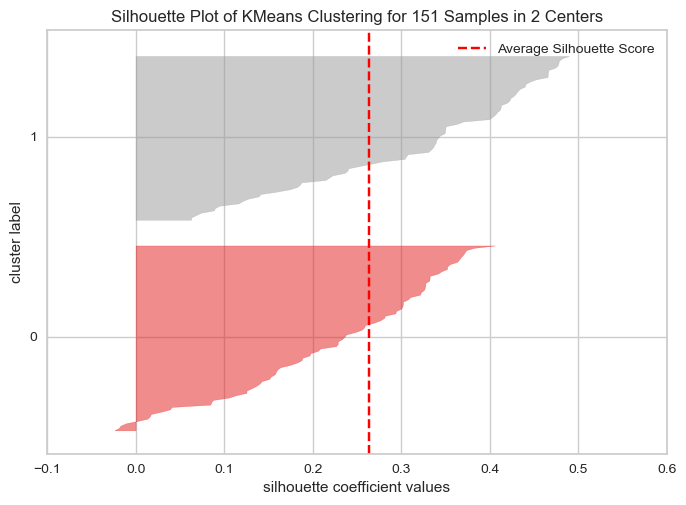

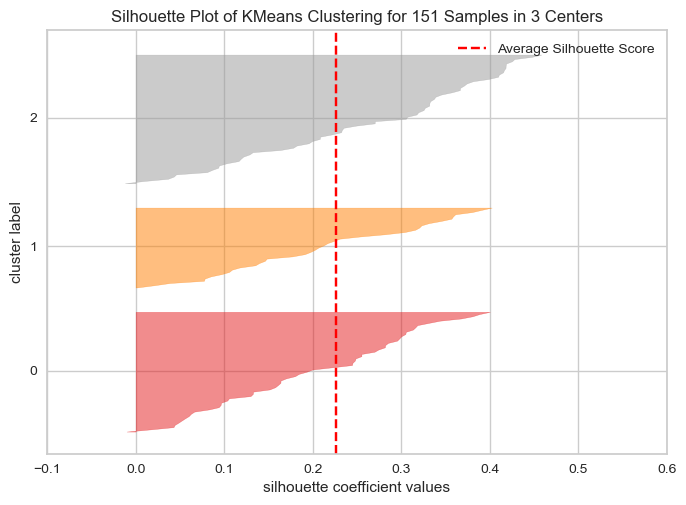

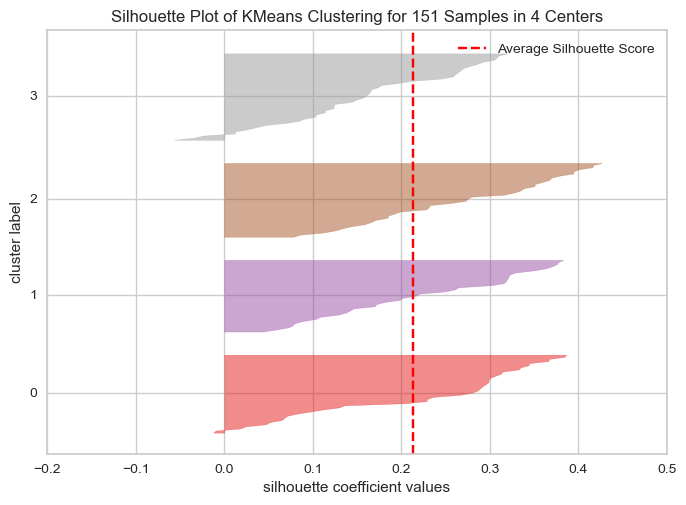

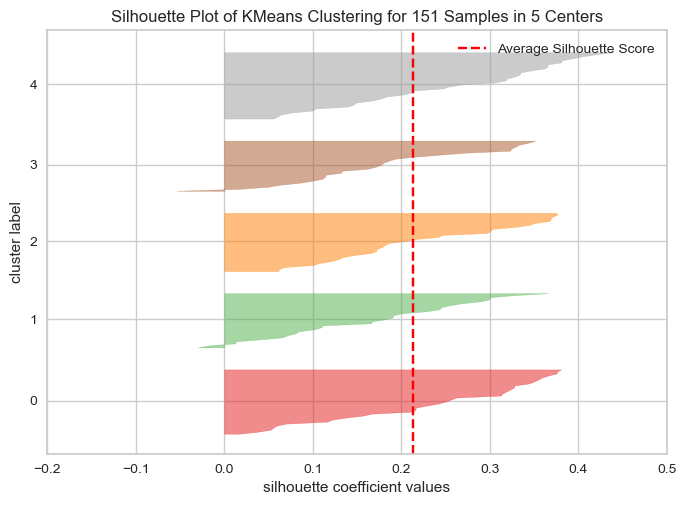

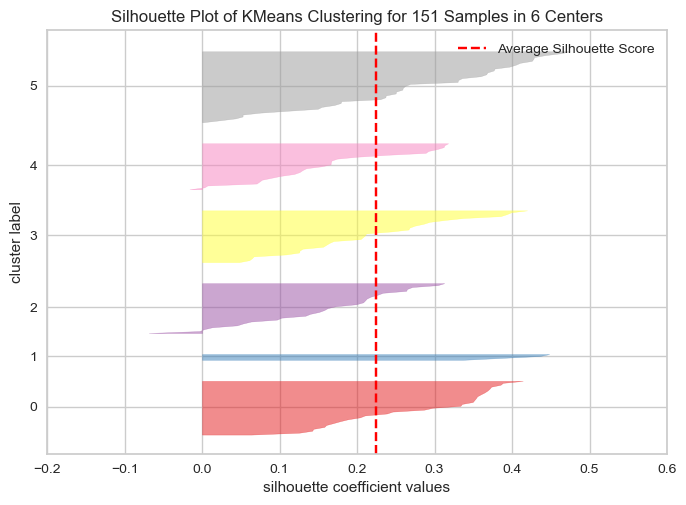

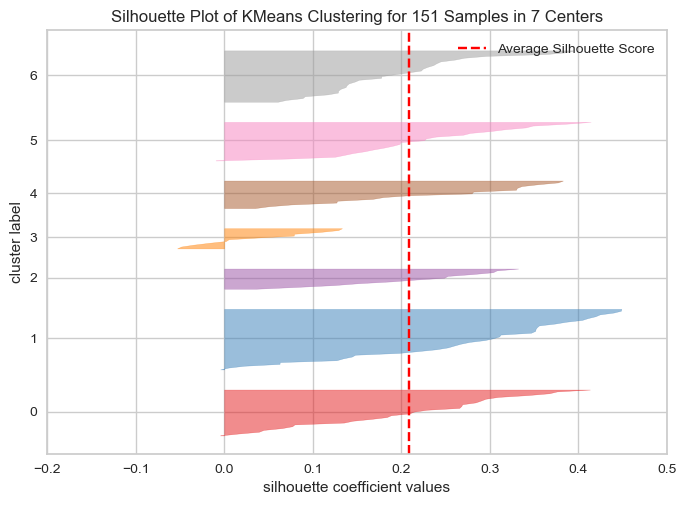

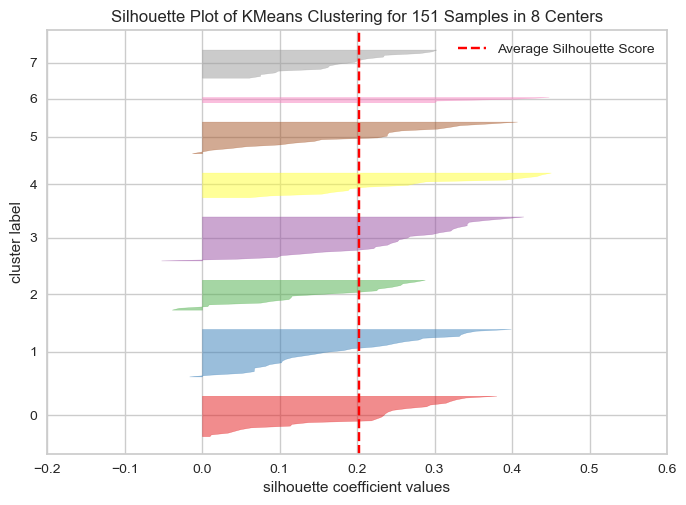

In [15]:

for i in range (2, 9):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=1)
    visu= SilhouetteVisualizer(km, color='yellowbrick')
    visu.fit(X_scaled)
    visu.show()

Si on suit la méthode de la silhouette, elle nous préconiserait de se baser sur 2 clusters. Par contre, si on suit la méthode de la distorsion, elle nous préconise plutôt 3 clusters. Au vu du nombre d'individus à analyser et notre objectif d'étude, j'ai préféré partir sur la méthode de distorsion pour affiner l'analyse.

* [sommaire](#sommaire)

<a class="anchor" id="II.b.2"></a>
<h2 style="text-align: center;text-decoration:bold;color:#736767;background-color:#F2DAEF"> Application du K-Means</h2>




In [16]:
n_clust= 3
# application du K-means avec le nombre de clusters optimal
km=KMeans(n_clusters=n_clust,init='k-means++', max_iter=300, n_init=10, random_state=8)
y_means= km.fit_predict(X_scaled) # entrainement du jeu de données
#y_means= km.fit(X_scaled)
clusters=km.labels_     # n° des clusters affectés aux groupes
centroids= km.cluster_centers_

CKmeans=pd.DataFrame({'clusters':clusters, "names":names})
km.n_iter_       #Nb d'itérations pour converger

CKmeans.groupby("clusters").count()

,names
clusters,
0,38
1,55
2,58


In [17]:
R2.iloc[n_clust -1:n_clust]

,interclasse,intraclasse,Distortion,Inertie totale,R2
2,106.59568,36.97114,0.464674,143.56682,2.883213


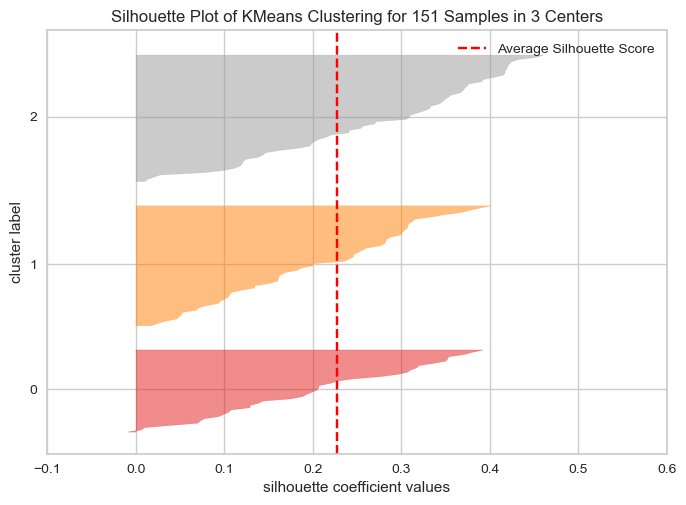

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 151 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [18]:
# SILHOUETTE => montre la densité et la séparation entre chaque cluster (+1= grande distance séparant clusters et -1 assigne mauvais cluster)
# ligne rouge = score moyen sur tous les clusters si sous la lignes donc déséquilibrer. 

visu= SilhouetteVisualizer(km, color='yellowbrick')
visu.fit(X_scaled)
visu.show()

On remarque que les pays sont assez bien répartis entre les 3 clusters. Seul le groupe 0 contient moins de pays et possède de potentiels outliers. Tous les clusters sont au-dessus du coefficient Moyen

In [19]:
Data_scaled['Classes']= clusters
Moyen_Scaled= Data_scaled.groupby("Classes").mean()

#PCA_clusters = pd.DataFrame({"Dim1" : centroids[:,0], "Dim2" : centroids[:,1],
#                          "Dim3" : centroids[:,2], "Dim4" : centroids[:,3],
#    "Classes" : Moyen_Scaled.reset_index()["Classes"]})


Table_classe = etuds.assign(classe = km.labels_) # tables avec toutes les variables non log
table_classe = data.assign(classe = km.labels_)
Moyen_classe =Table_classe.groupby("classe").median()

* [sommaire](#sommaire)

<div>
    <a class="anchor" id="III"></a>
<h2 style="text-align: center; text-decoration:bold; margin: auto; padding: 5px; color:#36151D;">III) Analyse des Clustering</h2>
</div>


<div style="background-color: #F56086;">
    <a class="anchor" id="III.a"></a>
<h2 style="text-align: center; text-decoration:bold; margin: auto; padding: 5px; color:#36151D;"> a. Comparaison des clusters<a class="anchor" id="III.a"></a>


<a class="anchor" id="III.a.1"></a>
<h2 style="text-align: center;text-decoration:bold;color:#736767;background-color:#F2DAEF"> Clusters du CAH</h2>




,Population,evolution8an%,Populationlog,Disponibilité de protéines en quantité (g/personne/jour),Txdependance,volaille,%ViandesurNourriture,%VolaillesurViandes,%VolaillesurNourriture,Evolviande_total1ans,Evolvolaille1ans,Food price inflation,"Pouvoir achat Volaille, Indices d'alimentation (2015 = 100)","Prix à la Consommation, Indices généraux (2015 = 100)","Pouvoir achat Volaille, Indices d'alimentation (2015 = 100) log",Indice des prix à la production (2014-2016 = 100),Prix à la Production (USD/tonne),Indice Evol prix production (France=100),Indice de quantité d'importation (2014-2016 = 100),Indice de valeur des importations (2014-2016 = 100),Indice de valeur unitaire à l'import (2014-2016 = 100),Valeur des importations - Prix période de référence,Valeur des importations - Quantité période de référence,Valeur des importations - Prix période de référence log,Valeur des importations - Quantité période de référence log,Croissance annuelle US$,Valeur US $,Valeur US $ par habitant,Valeur US $ par habitant log,Nombre d'enfants de moins de 5 ans présentant un excès pondéral (estimation modélisée) (millions),Prévalence de l'excès pondéral chez l’enfant de moins de 5 ans (estimation modélisée) (%),Stabilité politique et absence de violence/terrorisme (indice),dist
classe,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,23781.030800,19.349900,9.761378,1.696333,9.262122,112.233333,0.057700,0.167100,0.009033,-0.010691,0.033349,34.848479,468.252108,438.882546,5.118010,111.948000,1974.368333,109.419000,261.066667,194.666667,99.400000,6383.033333,6445.600000,7.361081,7.034969,1.064494,50202.153971,1844.560778,7.160948,0.150233,4.966667,-0.893667,-6129.524933
2,198398.795600,15.530400,12.158660,1.548000,0.289855,1135.800000,0.061400,0.123800,0.009200,0.021778,0.016806,13.174302,159.053925,152.725282,5.045524,114.218000,1954.450000,111.638000,156.600000,101.200000,170.000000,432.400000,1792.800000,4.319014,6.060459,0.173735,434449.401061,1992.656233,7.460217,1.040000,4.380000,-1.374000,-7147.655400
3,8933.417214,16.800000,8.438221,2.781786,72.055346,67.857143,0.077857,0.179393,0.012214,0.035416,0.073074,7.321148,135.866537,132.013109,4.875480,111.286071,2000.260714,108.771071,277.821429,215.571429,90.142857,55382.178571,39839.607143,10.208734,9.611322,-6.686771,24687.448991,3540.427734,7.854553,0.043571,5.871429,-0.001786,-6794.878393
4,17823.542417,8.464208,9.041115,12.668750,12.611086,674.750000,0.124292,0.487708,0.059833,-0.007071,-0.018205,7.299143,139.587731,134.594521,4.865933,132.412917,2032.922917,129.422917,273.458333,216.083333,92.791667,66454.625000,44410.833333,9.811780,9.375236,-8.512906,156864.097533,9214.615517,8.791394,0.112958,7.800000,0.066667,-9757.538583
5,6563.472188,14.943688,8.200216,11.396875,88.379766,228.312500,0.122562,0.458625,0.052500,0.064187,1.458261,6.451262,124.975011,121.293612,4.795638,114.340000,2375.546875,111.756250,124.937500,117.375000,93.437500,274441.187500,313670.250000,11.815471,11.571709,-11.116302,118791.353723,16895.750757,8.981453,0.019375,5.818750,-0.000000,-5764.324562
6,64451.627450,7.436900,10.373685,8.178500,13.103649,1768.550000,0.091250,0.374900,0.033550,0.004764,0.030033,17.987508,154.814557,140.204671,4.967371,119.625500,1985.270000,116.924500,550.900000,286.200000,91.250000,220972.200000,178141.150000,10.670521,10.430196,-2.112941,697496.285203,8874.040362,8.761264,0.370200,9.695000,-0.682500,-4498.550350
7,17204.002643,2.015964,9.026862,9.700714,42.788156,446.892857,0.081821,0.353000,0.028250,0.000200,0.006683,2.455167,108.983330,106.510719,4.689681,101.978929,1956.578571,99.677143,113.785714,104.178571,90.857143,265389.035714,230549.750000,11.757803,11.563585,-2.312514,614202.518206,35238.972548,10.305985,0.025179,2.671429,0.737857,-1467.570300


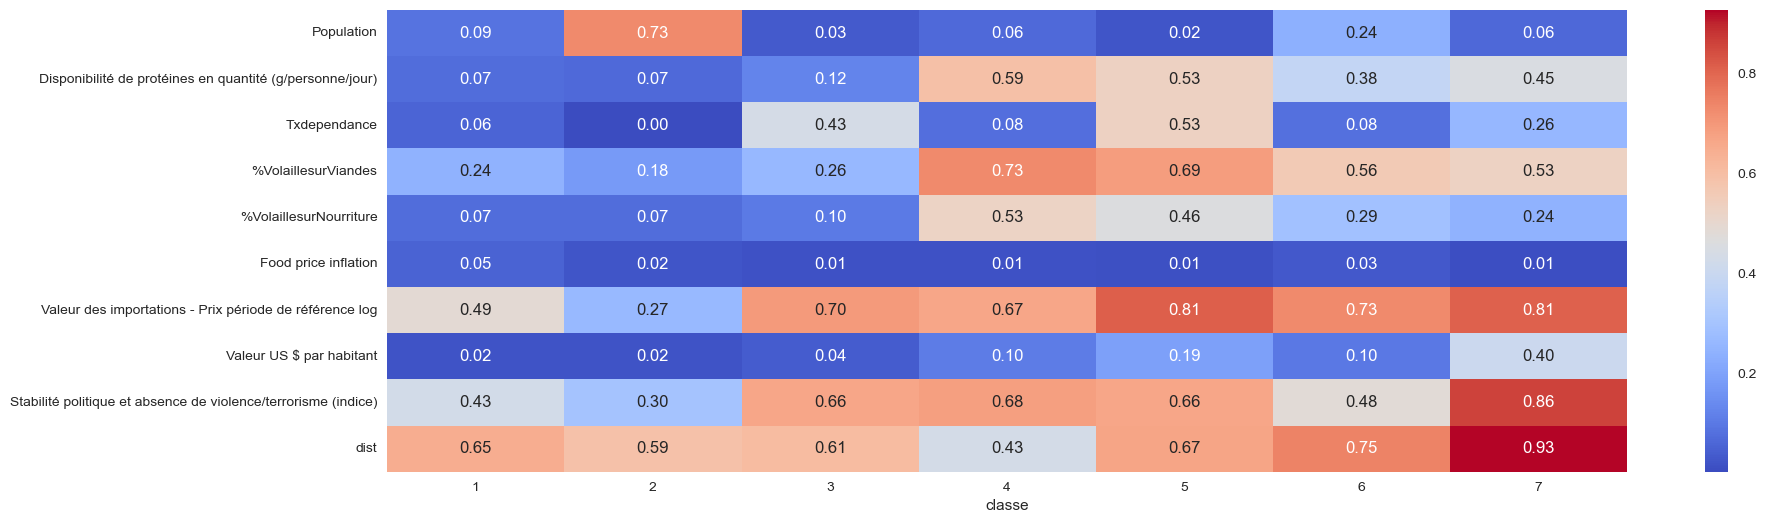

In [20]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(Dendo_classe1.transpose(), annot=True, cmap="coolwarm", fmt="0.2f")

Dend_classe1 # informations moyennes par classe. 

Toutes les valeurs indiquées sont des moyennes. <br>
**cluster 1**: Ce cluster représente les pays les plus pauvres autour de 1 844 UDS dollars par habitant en moyenne ayant une faible stabilité politique autour de -0.89 et une faible consommation de volaille et de viande autour de 1.69 . Ces pays sont assez éloignés de la France autour de 6130 km en moyenne avec un montant d'importation de volaille assez présente autour de 6 383 milliers $ en moyenne mais un faible taux de dépendance de l'importation de volaille autour de 9%. La Population y est assez élevée à la 3e position des clusters les plus peuplés autour de 23 781 habitants en moyenne. Ce cluster ne sera pas retenu pour l'étude de marché  <br><br>

**cluster 2**: Ce cluster représente les pays pauvres autour de 1 992 dollars USD dollars par  habitant en moyenne avec la plus faible stabilité politique autour de -1.37 en moyenne et la plus faible consommation de volaille et de viande autour de 1.54 g/pers/j ce qui représente 6% 12% des viandes. Le taux de dépendance et le montant des importations y est également le plus faible autour de 0.2 % ce qui représente 432 milliers $ en moyenne. Ces pays se trouvent assez éloignés de la France autour de 7147 km. Ce cluster ne sera pas non plus retenu pour l'étude de marché   <br><br>

**cluster 3**:  Ce 3e cluster représente toujours les pays pauvres autour de 3540 USD dollars par habitant en moyenne mais ayant une stabilité politique plus élevée autour de -0.001 et une consommation de volaille légèrement plus élevée que les autres pays pauvres autour de 2.78 g/perso/j en moyenne. La population y est faible autour de 8 933 milliers d'hab  et se trouve assez éloignée de la France autour de 6 794 km en moyenne. Par contre, l'importation et le taux de dépendance y est plus importante comparé aux 2 autres premiers clusters autour de 72% avec une valeur moyenne de 55 382 milliers de $. Au vu du faible potentiel, ce cluster ne sera pas encore sélectionné. A surveiller dans les années à venir si le marché s'accroit.  <br><br>

**cluster 4**: Ce 4e cluster représente les pays riches autour de 9 214 USD dollars par hab en moyenne les plus éloignés de la France autour de 9760 km en moyenne avec une assez bonne stabilité politique à 0.066 en moyenne, et une assez importante population autour de 17 823 milliers d'habitants en moyenne. La consommation de volaille y est la plus élevé autour de 12.66 g/perso/j en moyenne ce qui représente 49% des viandes consommées en moyenne avec le plus gros pourcentage de consommation toutes alimentations confondues qui atteint les 6% en moyenne. La valeur des importations restent assez élevé autour de 66 454 milliers $ en moyenne mais le taux dépendance y est très faible autour de 12% en moyenne. **Il pourrait être intéressant de mener une étude de marché sur ces pays** pour déterminer si nous pourrions faire concurrence avec les producteurs locaux. <br><br>

**cluster 5**: Ce 5e cluster représente les pays avec la plus faible population autour de 6 563 milliers d'habitants en moyenne, mais avec l'une des plus grandes consommations de volailles autour de 11.39 g/pers/jour en moyenne et elle représente 45% de la consommation de viande. Le taux de dépendance et la valeur des importations sont les plus élevées de tous les clusters avec un taux de 88% à hauteur de 274 441 milliers $ en moyenne. La stabilité politique est très présente autour de 0.0 et ces pays sont assez proches de la France autour de 5760 km en moyenne. Malgré, la faible population, ce marché reste un cluster à fort potentiel. **Il pourrait être intéressant de mener une étude de marché sur ces pays** pour déterminer si la concurrence y est forte ou non. <br><br>

**cluster 6**: Ce 6e cluster représente les pays assez riches autour de 8874 USD dollars par hab en moyenne, fortement proches de la France autour de 4500 km en moyenne avec une forte population autour de 64451 milliers d'habitants en moyenne. La consommation de volailles y est la plus faible des 4 derniers clusters autour de 8.17 g/perso/jour en moyenne mais avec une valeur d'importation assez élevée autour de 220 972 milliers de $ . La Stabilité politique y est également assez faible autour de -0.68 et le taux de dépendance à l'importation est très faible autour de 13% en moyenne. Ce cluster ne sera pas retenu. <br><br>

**cluster 7**: Ce dernier cluster représente les pays les plus riches autour de 35 238 $ par habitant en moyenne, les plus stables politiquement autour de 0.73 et les plus proches de la France à 1467 km en moyenne. La valeur des importations y est la plus élevée autour de 265 389 milliers de dollars. La consommation de viande y est assez présente autour 9 g/perso/jour en moyenne et 35% de la viande consommée. Cependant, le taux de dépendance y est assez faible autour de 42% en moyenne et le pourcentage de consommation de volaille par rapport à la nourriture globale est l'une des plus faibles et la plus faible des pays riches autour de 2% en moyenne. **Ce cluster pourrait être retenu seulement si l'étude de marché des précédents clusters ne sont pas concluantes**. En effet, malgré la plus faible consommation de volaille, les pays restent très attractifs car ils sont proches de la France et ont un fort PIB par habitant. <br><br>

* [sommaire](#sommaire)

<a class="anchor" id="III.a.2"></a>
<h2 style="text-align: center;text-decoration:bold;color:#736767;background-color:#F2DAEF"> Clusters du Kmeans</h2>


,Population,evolution8an%,Populationlog,Disponibilité de protéines en quantité (g/personne/jour),Txdependance,volaille,%ViandesurNourriture,%VolaillesurViandes,%VolaillesurNourriture,Evolviande_total1ans,Evolvolaille1ans,Food price inflation,"Pouvoir achat Volaille, Indices d'alimentation (2015 = 100)","Prix à la Consommation, Indices généraux (2015 = 100)","Pouvoir achat Volaille, Indices d'alimentation (2015 = 100) log",Indice des prix à la production (2014-2016 = 100),Prix à la Production (USD/tonne),Indice Evol prix production (France=100),Indice de quantité d'importation (2014-2016 = 100),Indice de valeur des importations (2014-2016 = 100),Indice de valeur unitaire à l'import (2014-2016 = 100),Valeur des importations - Prix période de référence,Valeur des importations - Quantité période de référence,Valeur des importations - Prix période de référence log,Valeur des importations - Quantité période de référence log,Croissance annuelle US$,Valeur US $,Valeur US $ par habitant,Valeur US $ par habitant log,Nombre d'enfants de moins de 5 ans présentant un excès pondéral (estimation modélisée) (millions),Prévalence de l'excès pondéral chez l’enfant de moins de 5 ans (estimation modélisée) (%),Stabilité politique et absence de violence/terrorisme (indice),dist
classe,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,10525.2420,11.2695,9.260796,13.71,15.333040,307.5,0.126,0.4925,0.058,0.011643,0.001210,3.578659,114.905290,111.298359,4.744108,107.45,1954.45,105.02,120.5,106.0,90.0,80104.0,41235.0,11.291042,10.626715,-10.444440,69562.653440,7796.879910,8.959175,0.100,7.45,0.055,-8758.9555
1,6979.1750,2.1870,8.850686,7.28,47.058824,124.0,0.075,0.3370,0.027,0.000000,0.008344,2.421746,110.319437,108.126433,4.703380,107.45,1954.45,105.02,111.0,102.0,90.0,104326.0,62102.0,11.555276,11.036533,-3.185781,68532.179747,13934.241955,9.542105,0.001,3.50,0.460,-1823.7090
2,16540.4105,18.0510,9.713542,1.34,7.730053,68.5,0.056,0.1405,0.008,0.000000,0.000000,5.101706,127.885808,123.710135,4.851126,107.45,1954.45,105.02,154.0,120.5,88.5,4055.5,2687.5,8.307718,7.896332,-0.858877,22702.920880,1507.528175,7.318221,0.100,4.55,-0.625,-6191.1740


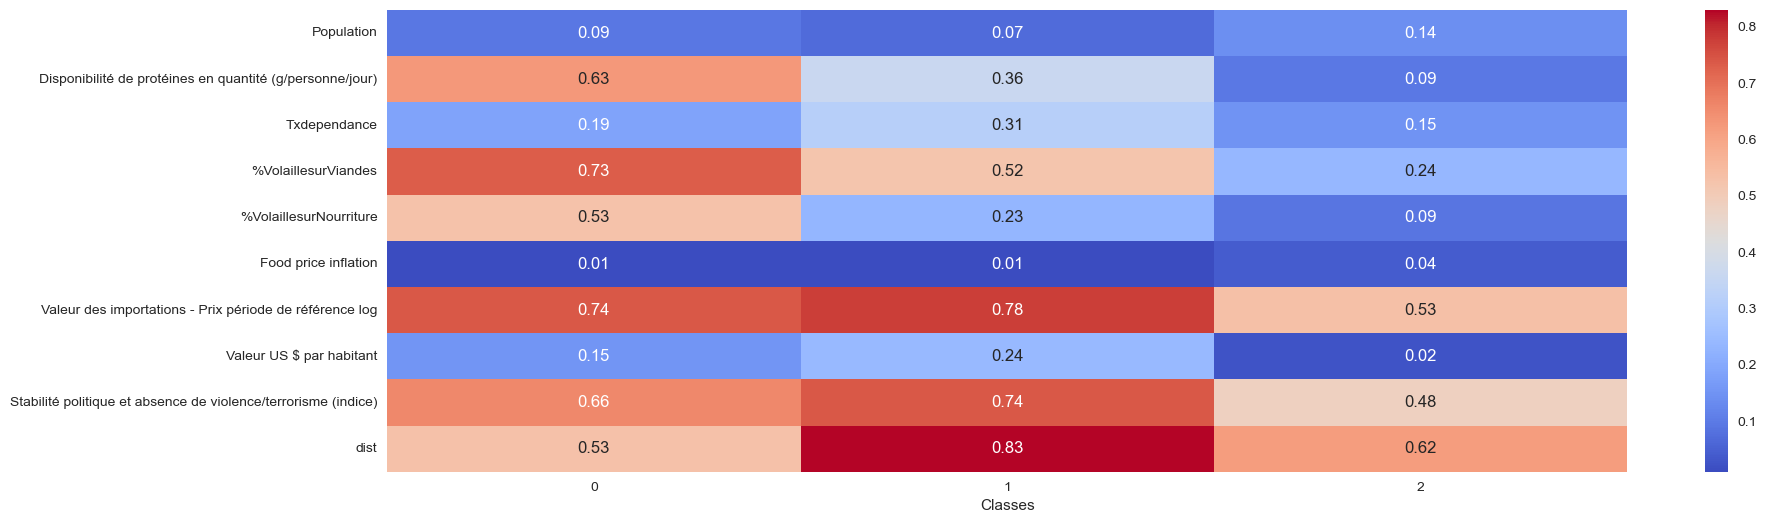

In [22]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(Moyen_Scaled.transpose(), annot=True, cmap="coolwarm", fmt="0.2f")

Moyen_classe # informations moyennes par classe. 

Toutes les valeurs indiquées sont des moyennes. <br>
**cluster 1** : Ce cluster représente les pays les plus éloignées autour de 8760 km en moyenne ayant la plus forte consommation de volaille en proportion par rapport à la viande ainsi que comparé à tous aliments confondus. Cette consommation de 13,71 g/perso/jour en moyenne représente environ 49% de sa consommation de viande et 5% de l'alimentation totale. Ces pays ont une assez forte population autour de 10 525 milliers en moyenne, sont assez riches autour de 7800 USD dollars par habitant et sont assez stables politiquement autour de 0.05. Les valeurs d'importations y sont assez importantes autour de 80 104 milliers de dollars $ mais leur taux de dépendance est assez faible autour de 15% de la consommation de poulet importée.  Malgré tout, ce cluster garde un fort potentiel. Il pourrait être intéressant d'analyser leurs coût de production. <br><br>

**cluster 2** : Ce cluster représente les pays les plus riches par habitant autour de  13 934$ en moyenne, les plus proches de la France autour de 1800km en moyenne avec la plus forte stabilité politique autour de 0.46 et la plus faible population autour de 6980 milliers d'habitants en moyenne. Leur consommation de volaille est moyenne avec le plus fort taux de de dépendance autour de 47% de la consommation importé de l'étranger en moyenne et la plus forte valeur d'importation autour de 104 326 dollars. La consommation de volaille représente 7,28 g/per/jour en moyenne et 33% de la consommation de viande. La volaille représente seulement 2%  de la consommation d'aliments en moyenne. Ce cluster pourrait être un potentiel cluster à analyser. Il pourrait être intéressant de vérifier la saturation commerciale de ce marché dans ces pays. <br><br>
 
**cluster 3** : Ce cluster représente les pays les plus pauvres avec un PIB par habitant moyen autour de 1507 USD$ et dont la stabilité politique est le plus faible  et la population est la plus élevée. En effet, ces pays comptent en moyenne 16 540 milliers d'habitants avec un index de stabilité de -0.62. La consommation de volaille y est également la plus faible autour de 1,34g/pers/jour avec un faible taux de dépendance autour de 7% en moyenne. La volaille représente seulement 14% de la viande consommée.  Ces pays sont assez éloignés de la France. Ce cluster n'est pas intéressant pour exporter de la France. Ce cluster ne sera pas retenu pour l'étude de marché <br><br>

* [sommaire](#sommaire)

<div style="background-color: #F56086;">
    <a class="anchor" id="III.b"></a>
<h2 style="text-align: center; text-decoration:bold; margin: auto; padding: 5px; color:#36151D;"> b. Visualision des clusters<a class="anchor" id="III.b"></a>


<a class="anchor" id="III.b.1"></a>
<h2 style="text-align: center;text-decoration:bold;color:#736767;background-color:#F2DAEF"> Visualisation sur Projection des Individus avec toutes les variables</h2>


# sur les clusters Kmeans

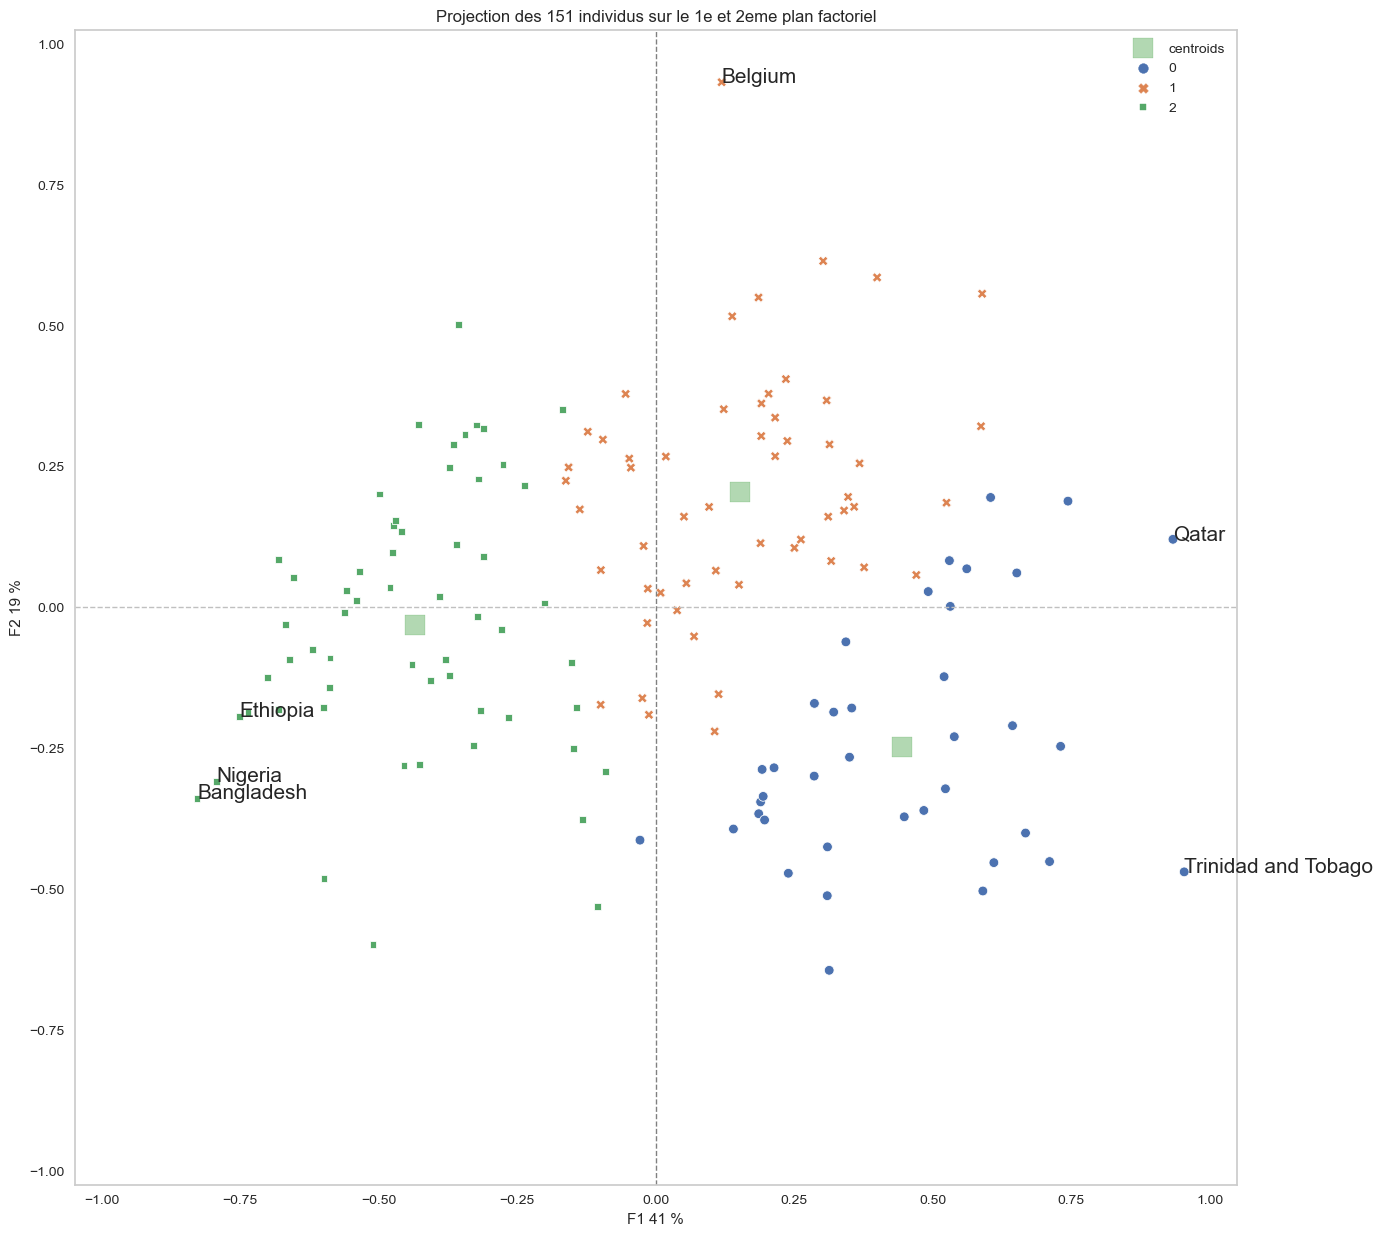

In [23]:
# projection des clusters sur l'axe 1 et 2
PCA_indiv2 = PCA_indiv.assign(classe=km.labels_)
centroids_projected = pca.transform(centroids)

display_factorial_planes(PCA_indiv2, "Dim1", "Dim2", 0,1, 0.75, 0.7, clusters, centroids_projected, (15,15))


On distincte bien clairement les 3 clusters sur les 2 premiers axes. 
<br>Le **Cluster 0** se trouve influencé positivement par l'axe 1 qui concerne la consommation de volaille et négativement sur l'axe 2 qui concerne le taux de dépendance. <br>
Le **cluster 1** se trouve également influencé positivement par l'axe 1 qui concerne la consommation de volaille et positivement sur l'axe 2 qui concerne le taux de dépendance. <br>
Le **cluster 3** se trouve influencé négativement  par l'axe 1 qui concerne la consommation de volaille mais est étalé  tout le long de l'axe 2. 

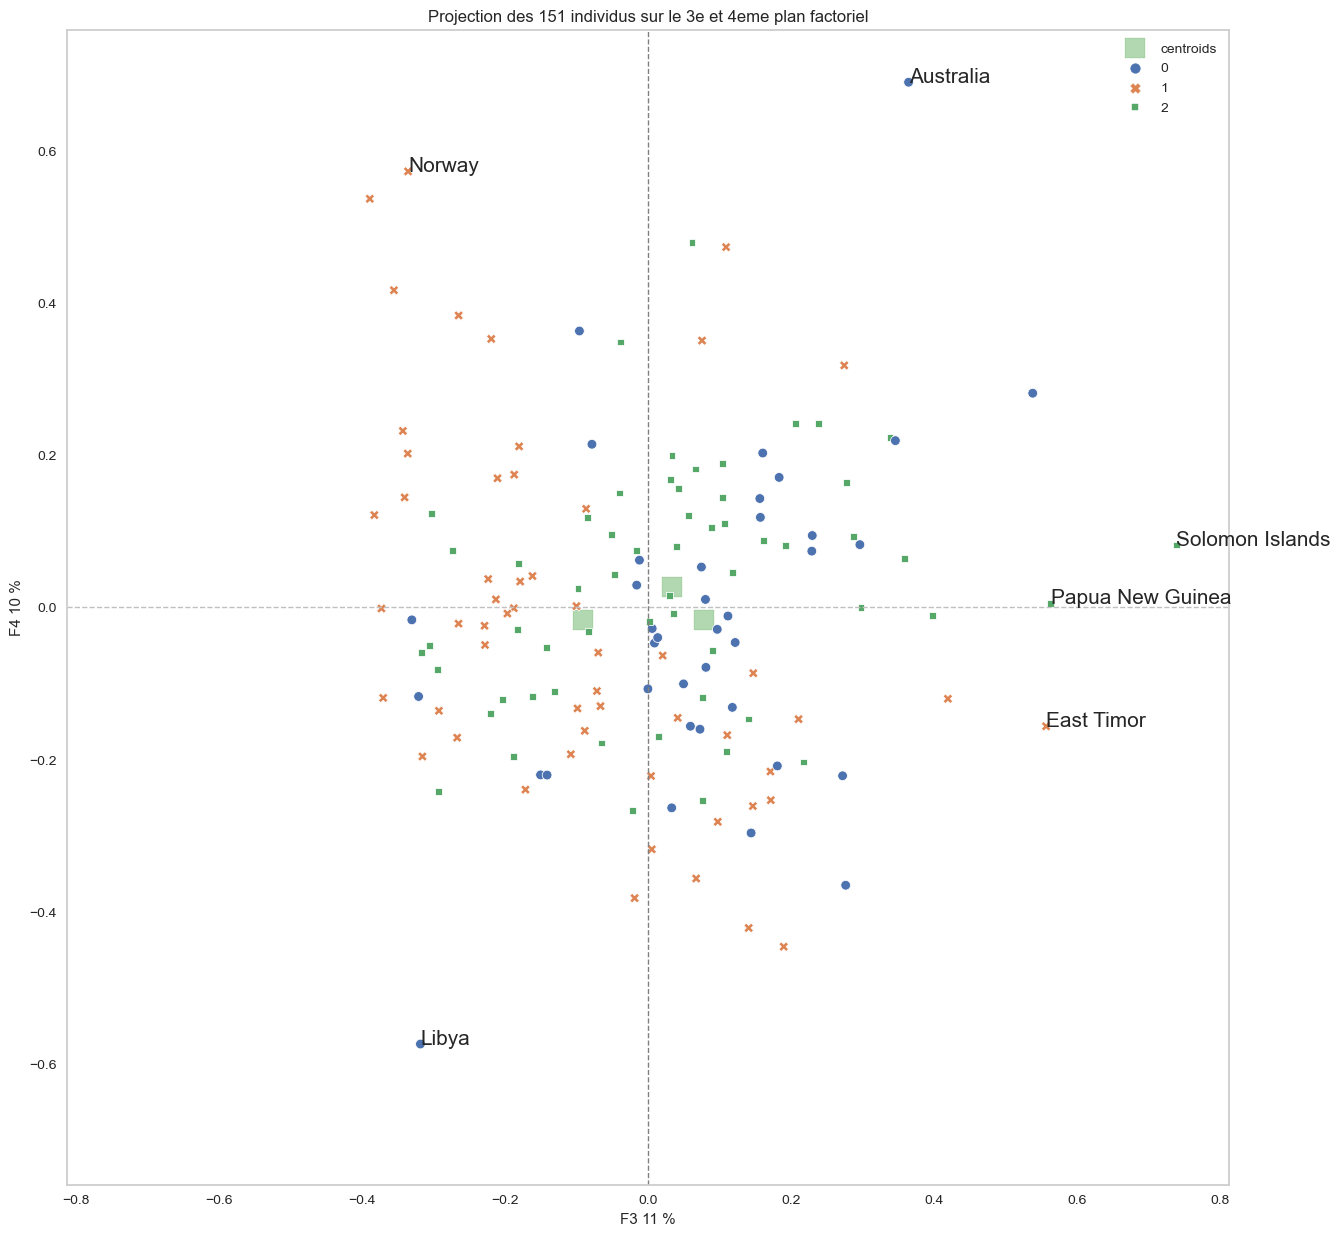

In [24]:
# projection des clusters sur l'axe 3 et 4
display_factorial_planes(PCA_indiv2, "Dim3", "Dim4", 2,3, 0.55, 0.55, clusters, centroids_projected)


Par contre la distinction est beaucoup moins clair sur les 2 axes suivants. En effet, les centroïds de ces clusters sont très proches. Cela signifie que les individus présents dans chaque classe ne sont pas nettement distingués par les variables qui influencent ces 2 axes et ont des caractéristiques communs ou proches.  <br>
Le **cluster 0** voit tout de même une certaine influence positive de l'axe 3 qui concerne la distance du Pays par rapport à la France. Ce cluster confirme bien un certain éloignement de la France.   <br>
Le **cluster 1** voit également une  certaine influence positive de l'axe 3 qui concerne la distance du Pays par rapport à la France. Ce cluster confirme bien un certain rapprochement de la France. <br>
Par contre le **Cluster 2** n'est pas du tout influencé par cet axe 3. <br> <br>
Concernent l'axe 4 sur la Stabilité Politique et le PIB par habitant, on ne distingue pas vraiment d'influence visuelle sur les clusters. Les centroïds sont quasiment au même niveau sur l'axe 4.   

# des clusters CAH

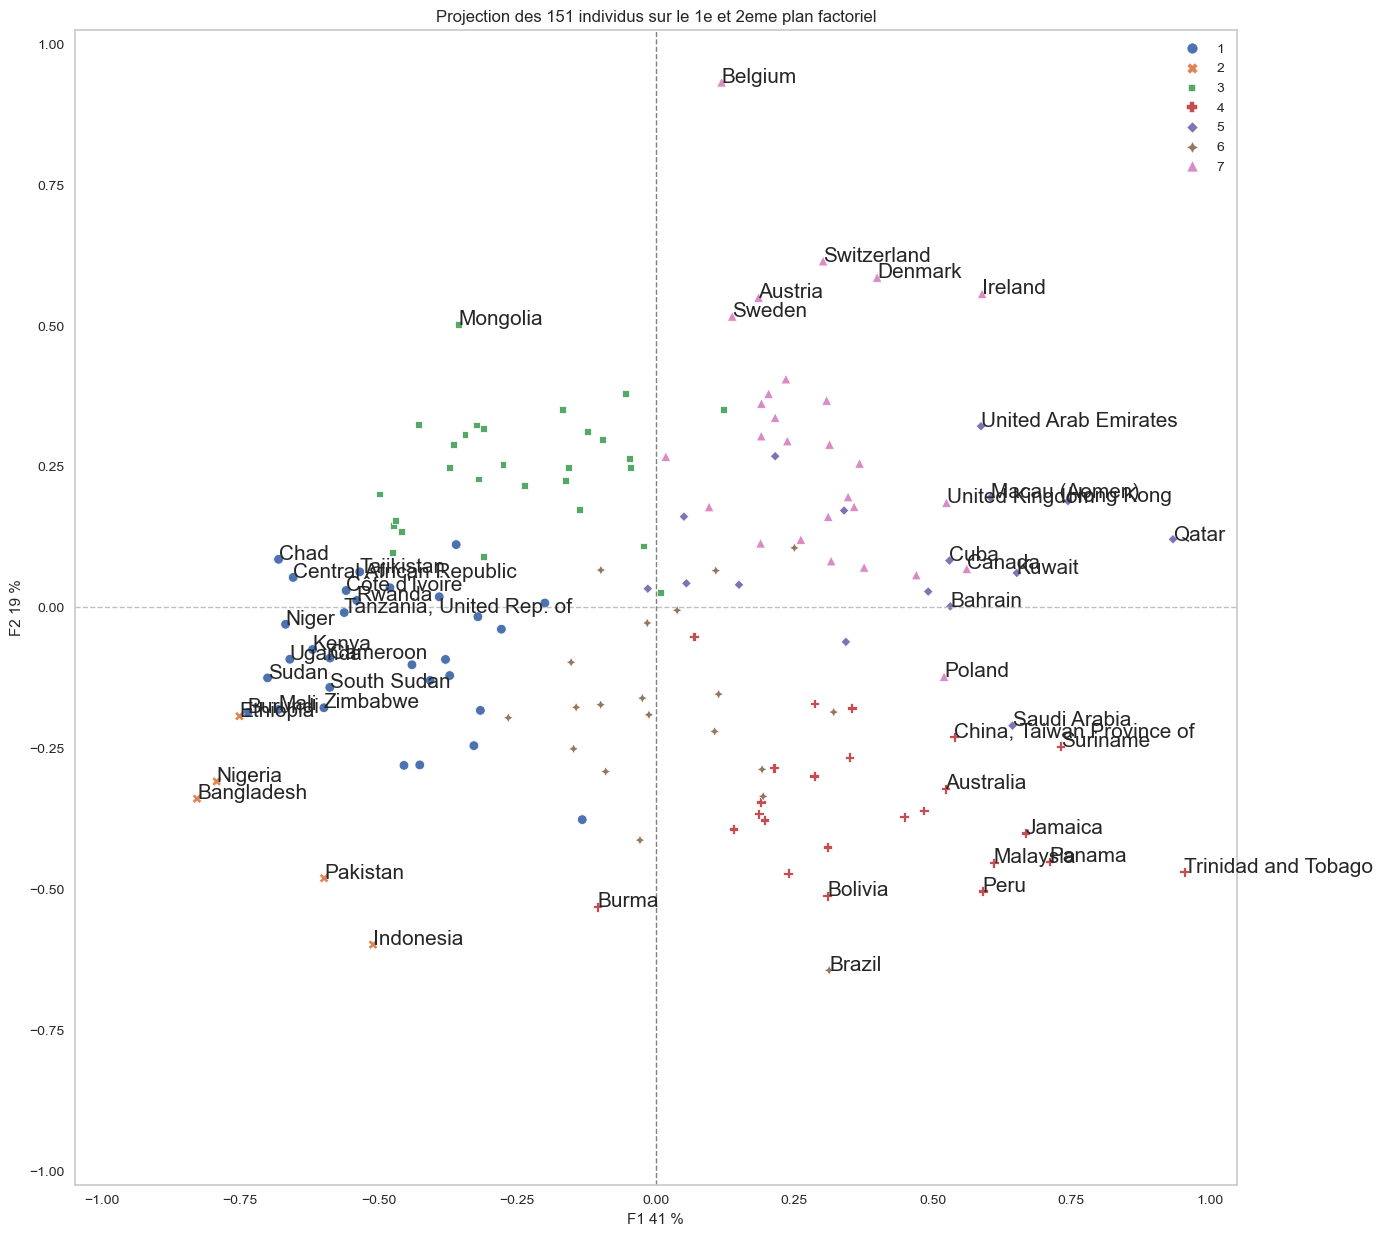

In [25]:
PCA_indiv3 = PCA_indiv.assign(classe=Clusters)

display_factorial_planes(PCA_indiv3,"Dim1", "Dim2", 0,1, 0.5, 0.5, Clusters, centroid= None)


La représentation des clusters du CAH sont très rapprochées entre eux. En effet, il y a eu pas mal de clusters différents avec des variables très similaires. On arrive tout de même à distinguer quelques clusters. <br> 
Les **clusters 1, 2 et 3** se trouvent influencés négativement par l'axe 1 qui concerne la consommation de volaille. <br> 
Les **clusters 4, 5 et 7** se trouvent influencés positivement par l'axe 1 qui concerne la consommation de volaille <br>
Par contre, le **cluster 6** n'a d'influence clair sur l'axe 1. <br><br>

Les **clusters 2, 4 et 6** se trouvent influencés négativement par l'axe 2 qui concerne le taux de dépendance. Ils sont donc peu dépendants à l'importation pour couvrir leur besoin. <br>
Les **clusters 3, 5 et 7** se trouvent influencés positivement par l'axe 2 qui concerne le taux de dépendance. Ils sont donc dépendants à l'importation pour couvrir leur besoin. <br>
Par contre, le **cluster 1** n'a d'influence clair sur l'axe 2. <br><br>

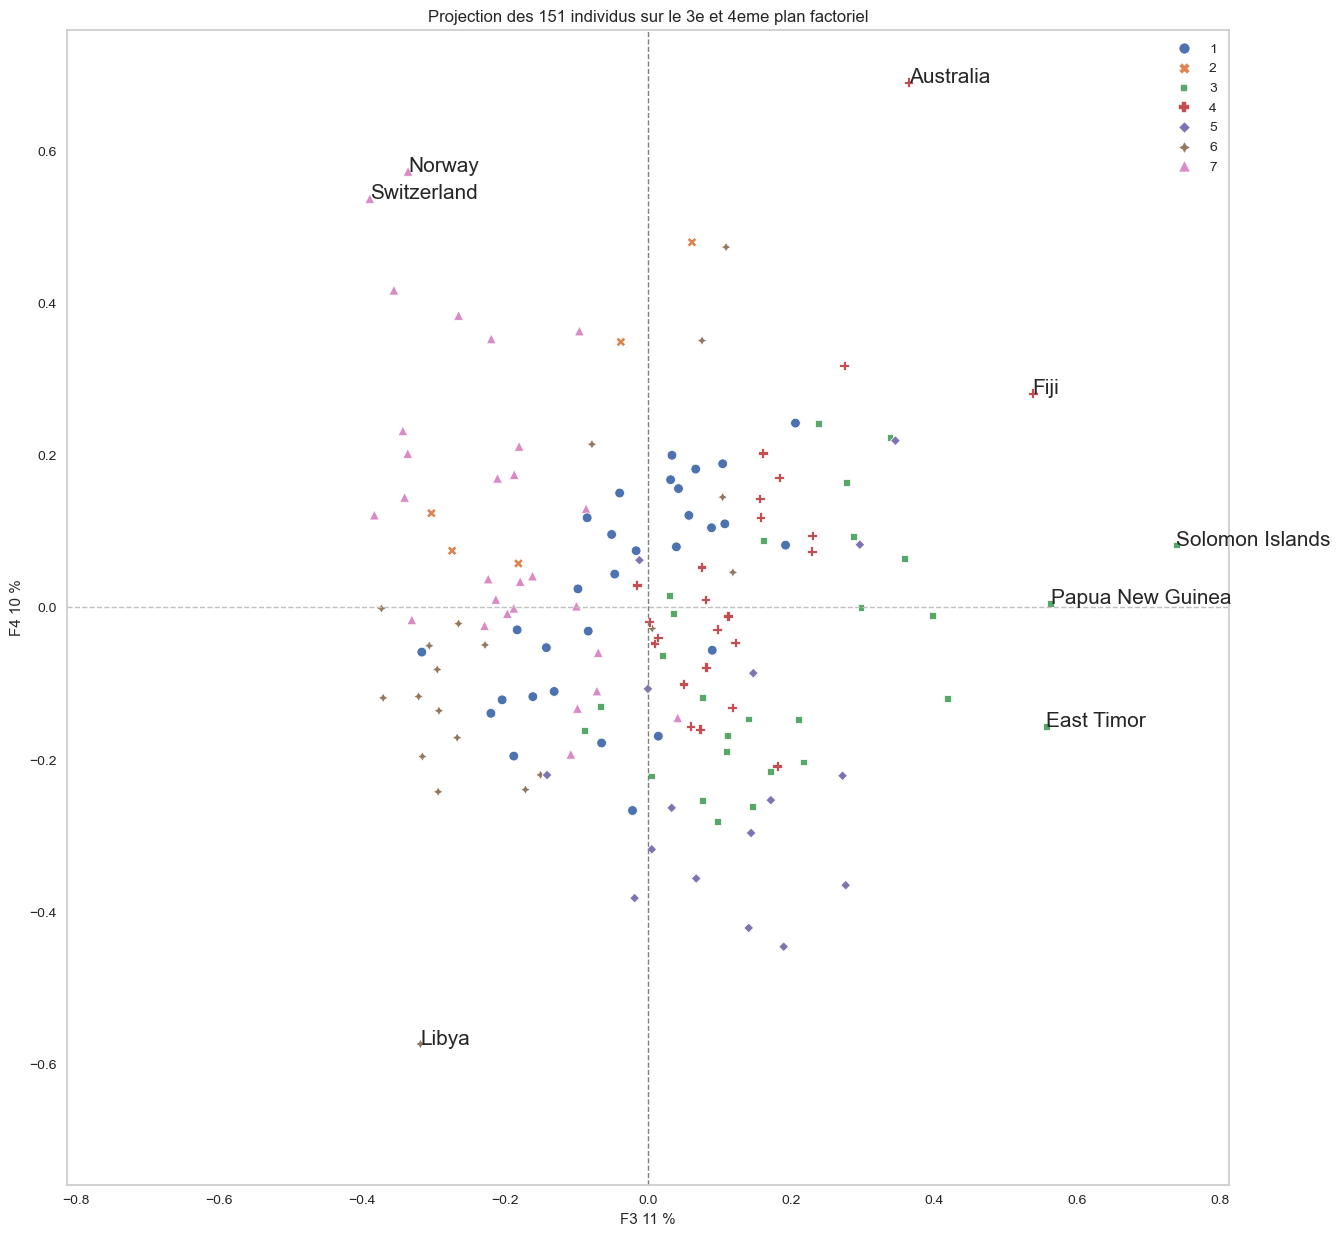

In [26]:
display_factorial_planes(PCA_indiv3,"Dim3", "Dim4", 2,3, 0.5, 0.5, Clusters, centroid= None)


Les **clusters 2 et 7** se trouvent influencés négativement par l'axe 3 qui concerne la distance du Pays par rapport à la France. Ce cluster confirme bien un certain rapprochement de la France.   <br>
Les **clusters 3, 4 et 5** se trouvent influencés positivement par l'axe 3 qui concerne la distance du Pays par rapport à la France. Ce cluster confirme bien un certain éloignement de la France.   <br>
Par contre, les **clusters 1 et 6** n'ont d'influence clair sur l'axe 3. <br><br>

Concernent l'axe 4 sur la Stabilité Politique et le PIB par habitant, on ne distingue pas vraiment d'influence visuelle sur les clusters également.

* [sommaire](#sommaire)

<a class="anchor" id="III.b.2"></a>
<h2 style="text-align: center;text-decoration:bold;color:#736767;background-color:#F2DAEF"> Visualisation sur Projection des Individus sur les 4 premières dimensions</h2>


# Kmeans sur 4 premières dimensions

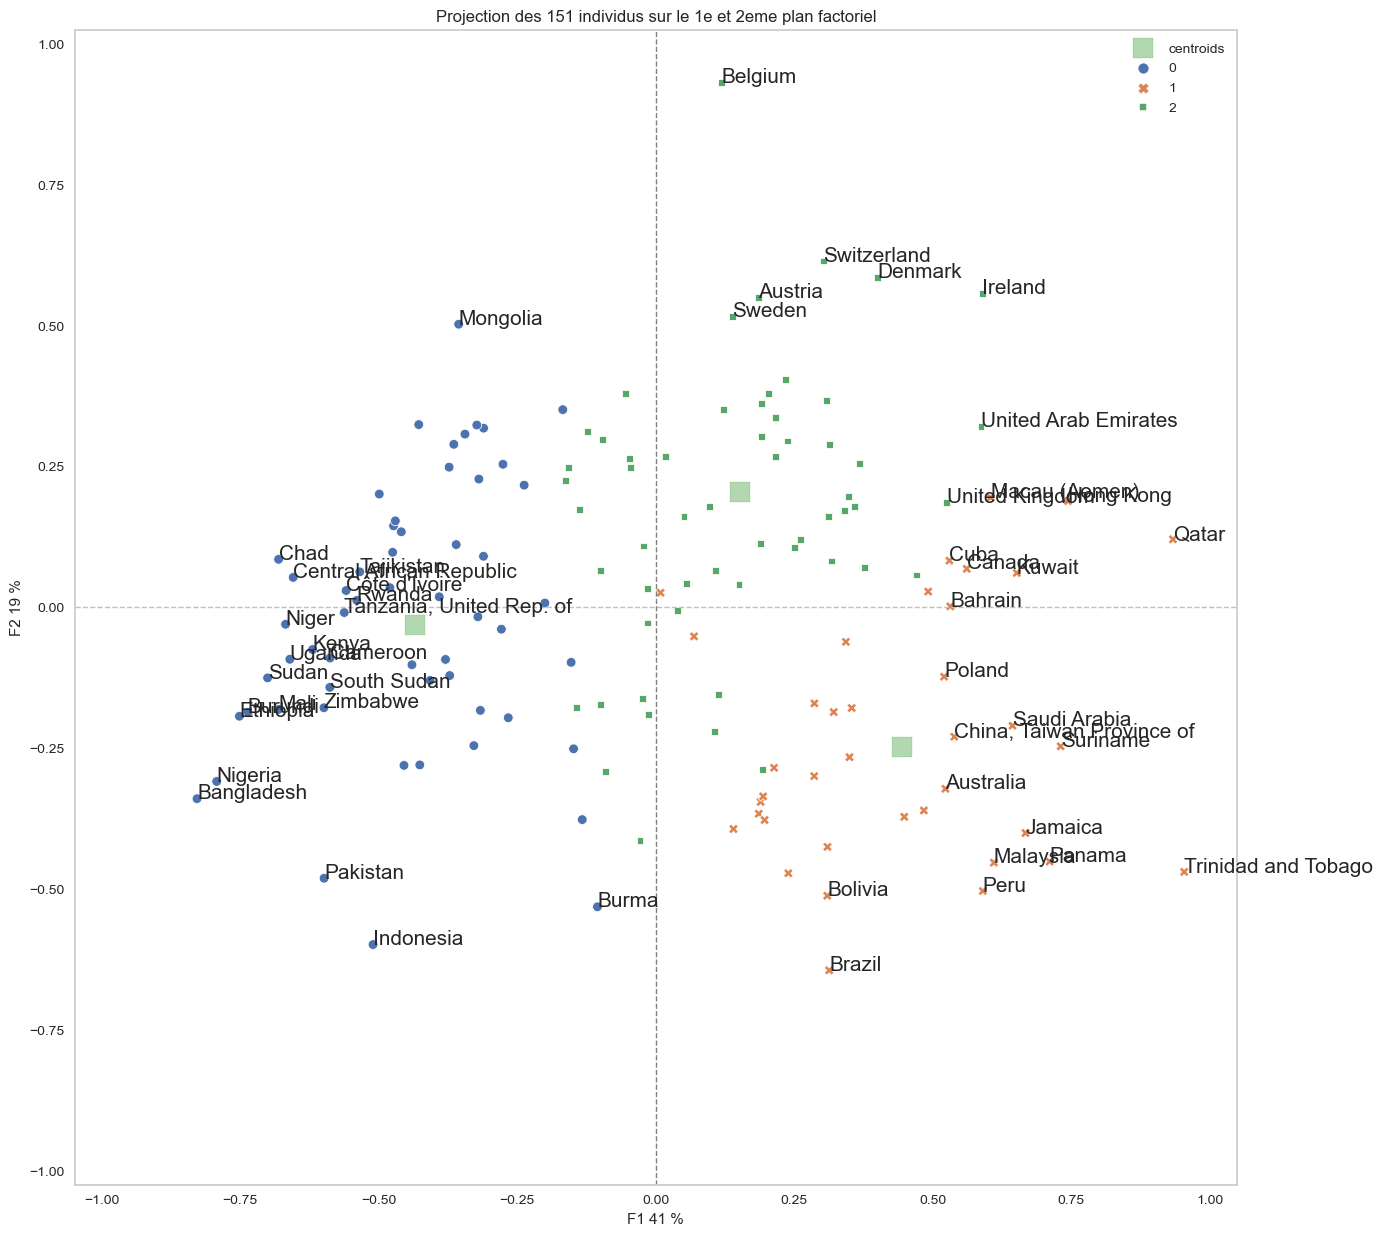

In [27]:
#Kmean sur données projetées
km2=KMeans(n_clusters=n_clust,init='k-means++', max_iter=300, n_init=10, random_state=8)
y_means2= km2.fit_predict(X_projected) # entrainement du jeu de données
clusters2=km2.labels_     # n° des clusters affectés aux groupes
centroids2= km2.cluster_centers_
CKmeans2=pd.DataFrame({'clusters':clusters2, "names":names})
km2.n_iter_       #Nb d'itérations pour converger

CKmeans2.groupby("clusters").count()

PCA_indiv4 = PCA_indiv2.assign(classe=km2.labels_)

display_factorial_planes(PCA_indiv4, "Dim1", "Dim2", 0,1, 0.5, 0.5,  clusters2, centroids2)


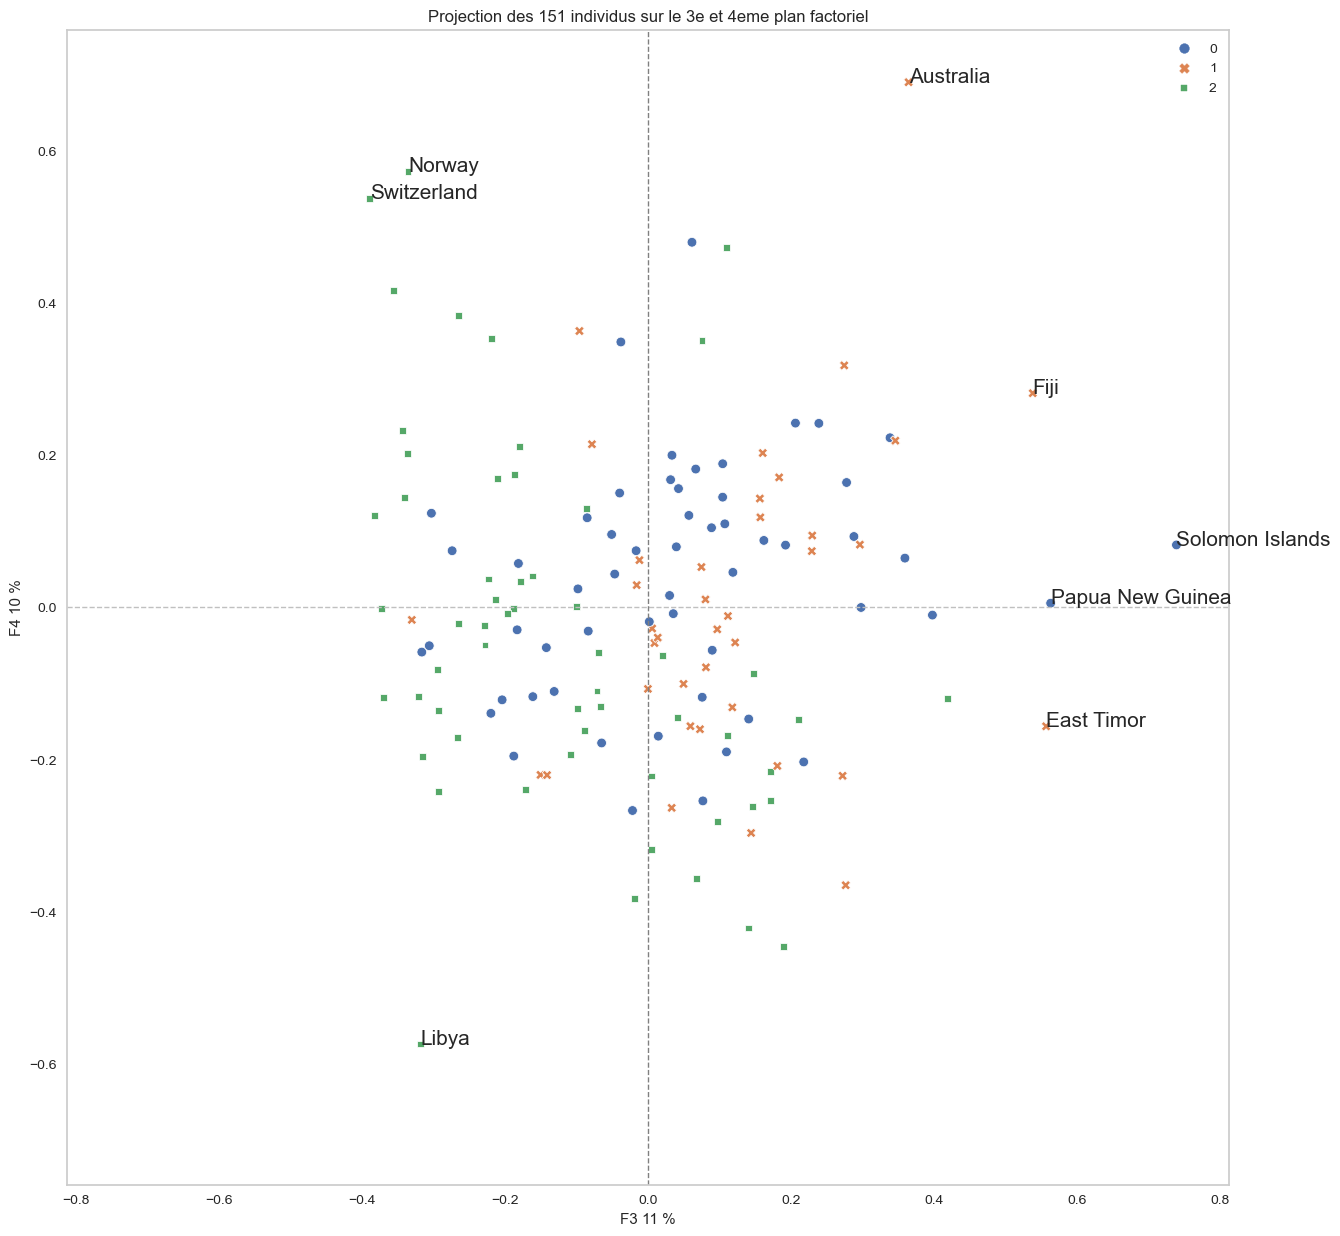

In [28]:
display_factorial_planes(PCA_indiv4, "Dim3", "Dim4", 2,3, 0.5, 0.5,  clusters2)


Pas de grands changements dans la représentation.

# CAH sur 4 premières dimensions

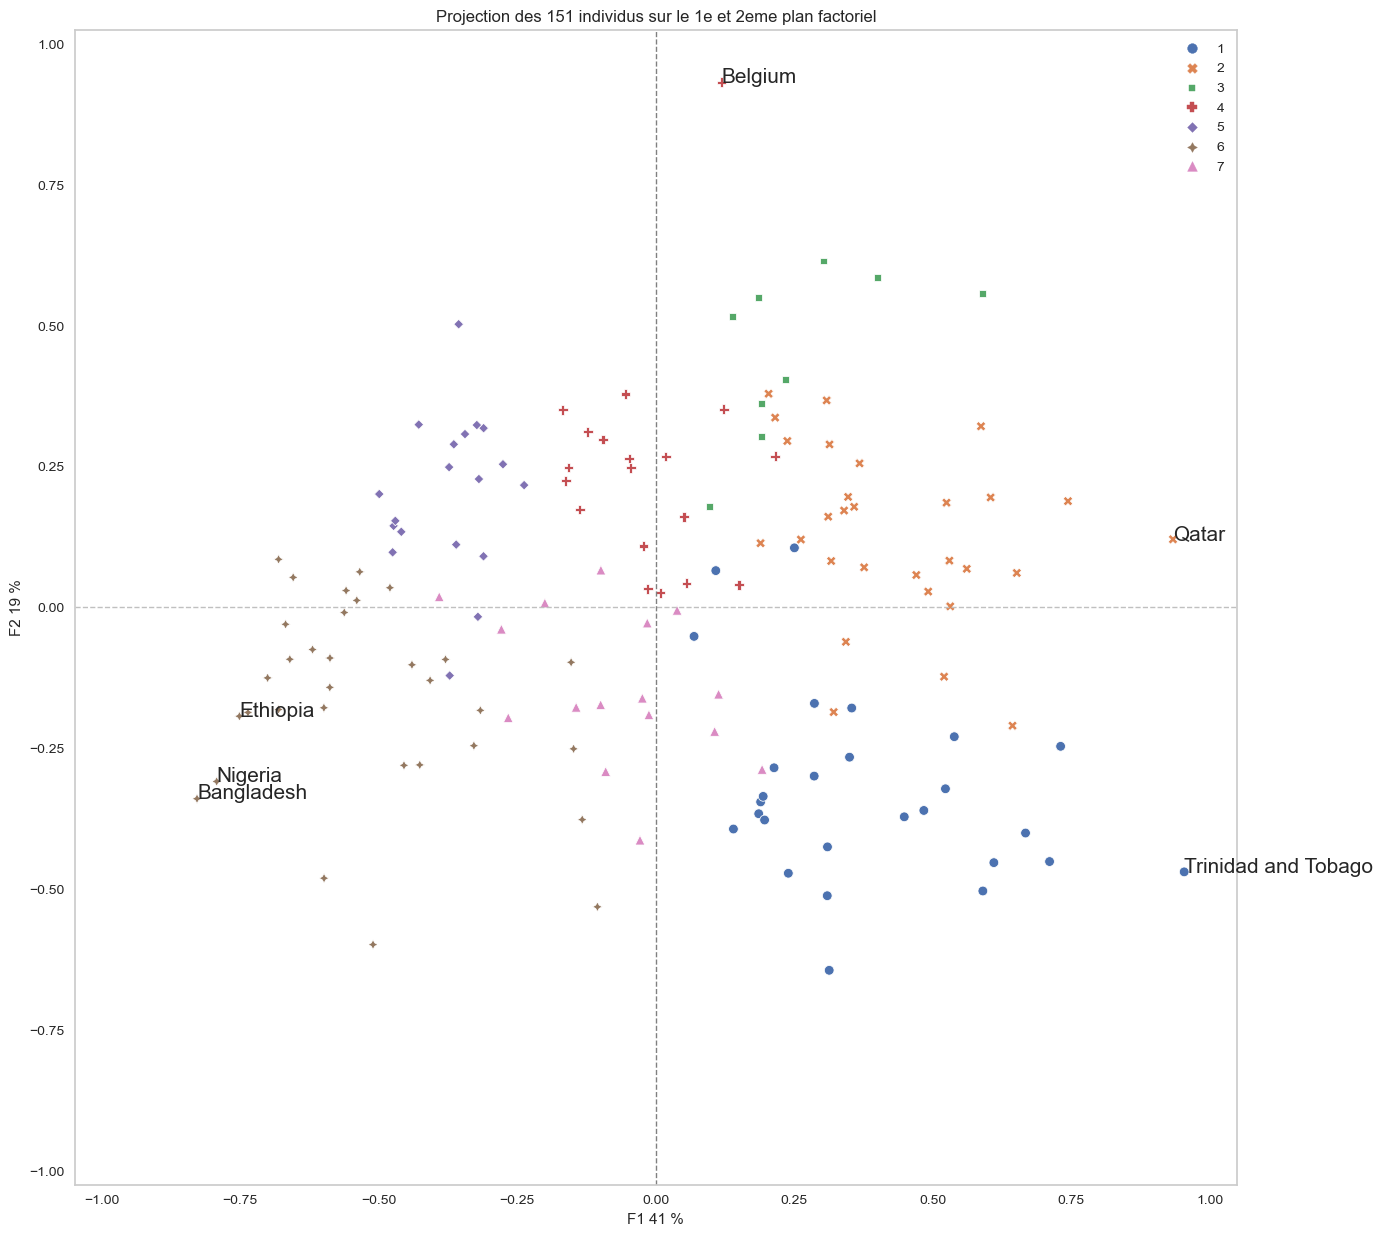

In [29]:
#CLASSIFICATION AH sur données projetées

Z = linkage(X_projected, method='ward', metric="euclidean", optimal_ordering=True)   # Méthode Ward
Clusters2 = fcluster(Z, 7, criterion='maxclust')  # 5 clusters 
PCA_indiv5 = PCA_indiv.assign(classe=Clusters2)

display_factorial_planes(PCA_indiv5, "Dim1", "Dim2", 0,1, 0.75, 0.75, Clusters2)


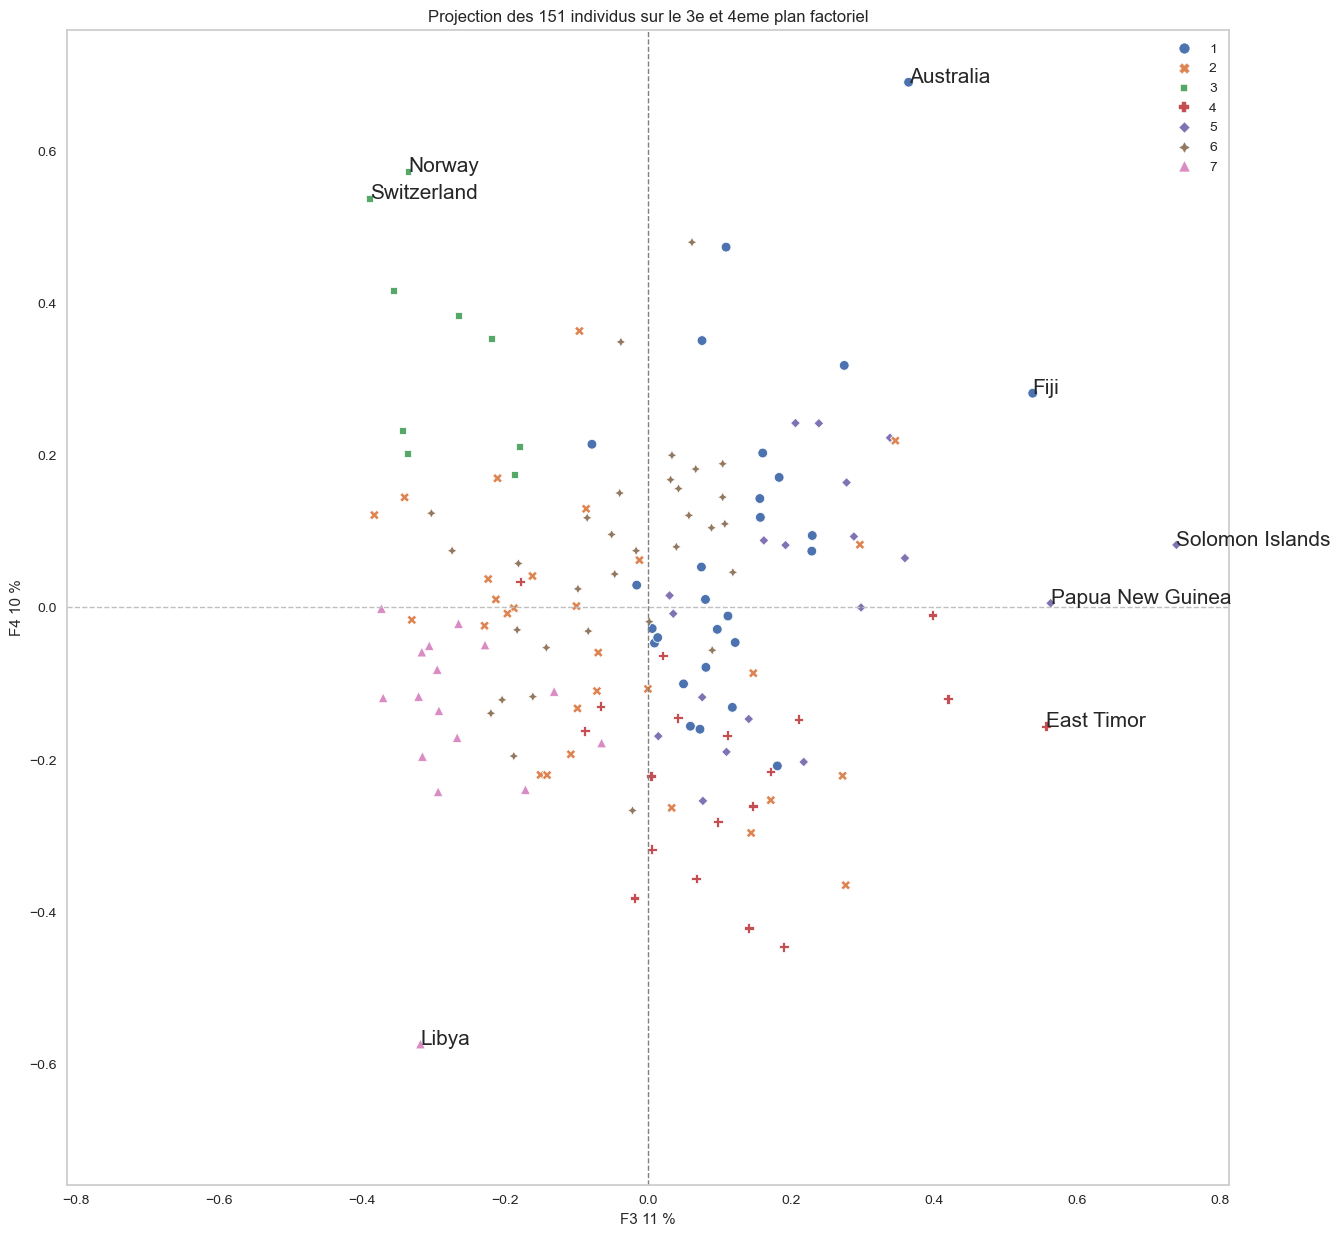

In [30]:
display_factorial_planes(PCA_indiv5, "Dim3", "Dim4", 2,3, 0.5, 0.5, Clusters2)


Légère amélioration de représentation des clusters mais elles restent assez mélangées.

* [sommaire](#sommaire)

<a class="anchor" id="III.b.3"></a>
<h2 style="text-align: center;text-decoration:bold;color:#736767;background-color:#F2DAEF"> Application et Visualisation Kmeans sur les classes 0 et 1</h2>

# Kmeans sur les classes 0 et 1 de Kmeans initiale

Text(0.5, 1.0, 'Heatmap sur la représentation des variables sur les différentes dimensions')

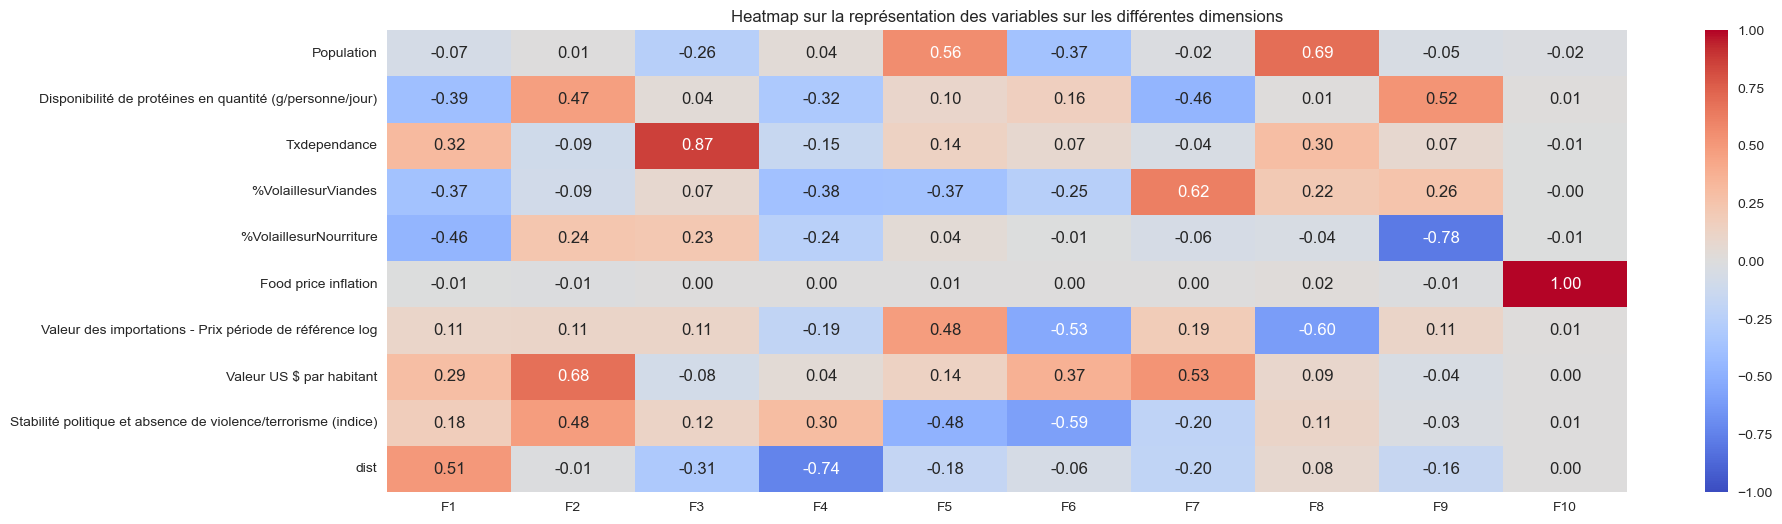

In [31]:
#Kmean sur classe 0 et 1
Data_scaledTrie= Data_scaled[(Data_scaled["Classes"]==0) |(Data_scaled["Classes"]==1) ]
Data_scaledTrie= Data_scaledTrie.drop(columns='Classes')
X= Data_scaledTrie.values
name= Data_scaledTrie.index        # stockage du nom des Individus (pays)

feature=Data_scaledTrie.columns    # Stockage du nom des variables 

n_comp= Data_scaledTrie.shape[1]   
pca=decomposition.PCA(n_components=n_comp)  
pca.fit_transform(X)               
X_project =pca.fit_transform(X)
# REPRESENTATION VARIABLES

pcs= pca.components_         # Vecteurs Propres

pcsvariable = pd.DataFrame(pcs)

x_list = range(1, n_comp+1)
list(x_list)

pcsvariable.columns = feature
pcsvariable.index= [f"F{i}" for i in x_list]

fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcsvariable.transpose(), vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")
plt.title("Heatmap sur la représentation des variables sur les différentes dimensions")


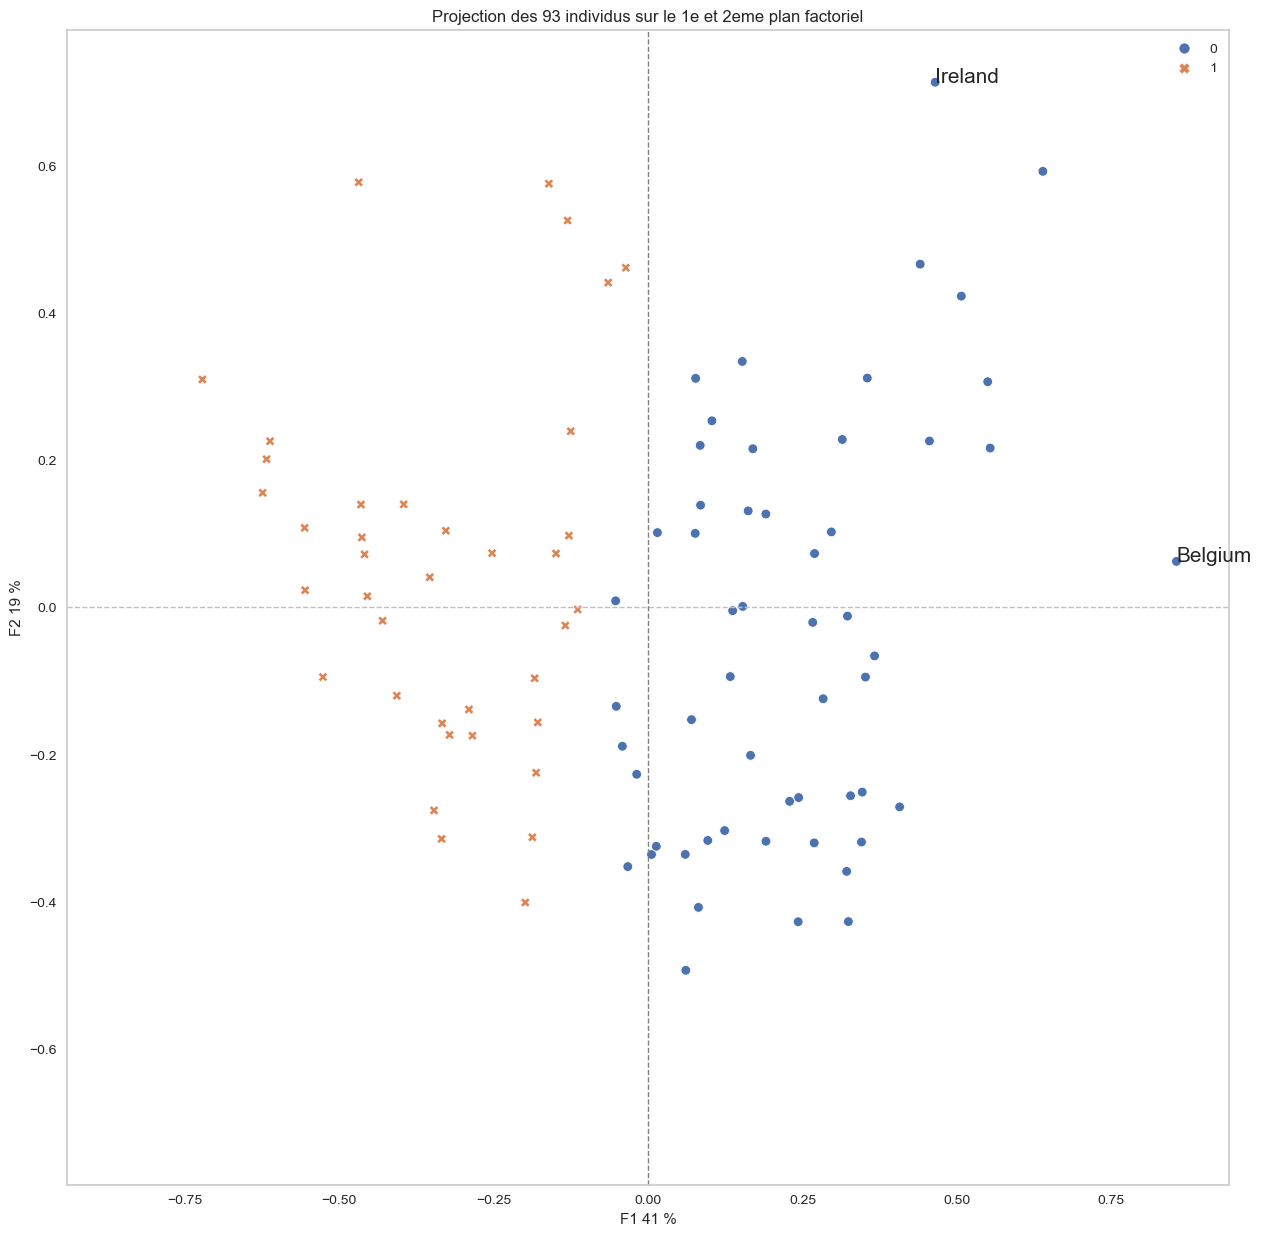

<AxesSubplot:xlabel='Classes'>

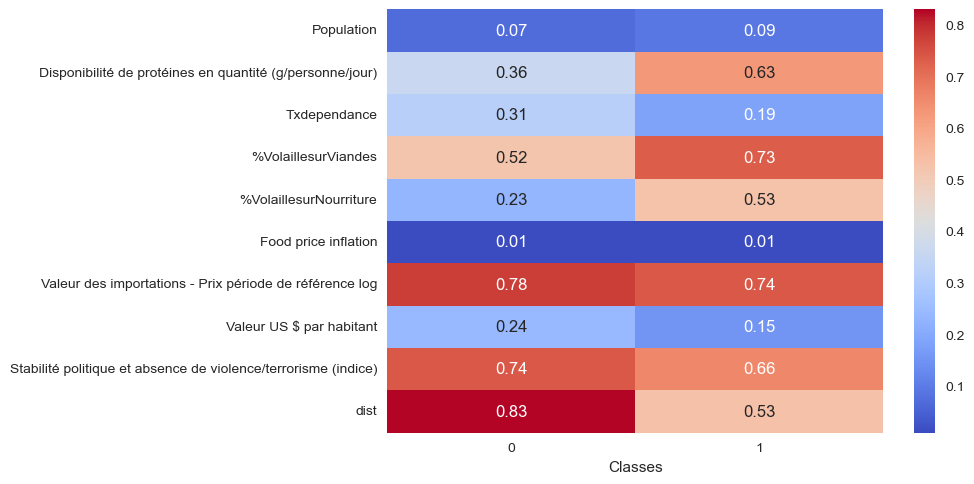

In [32]:
PCA_ind = pd.DataFrame({"Dim1" : X_project[:,0], "Dim2" : X_project[:,1],
                          "Dim3" : X_project[:,2], "Dim4" : X_project[:,3],
    "Country" : Data_scaledTrie.reset_index()["Area"]})

km3=KMeans(n_clusters=2,init='k-means++', max_iter=300, n_init=10, random_state=8)
y_means3= km3.fit_predict(X) # entrainement du jeu de données
clusters3=km3.labels_     # n° des clusters affectés aux groupes
centroids3= km3.cluster_centers_
CKmeans3=pd.DataFrame({'clusters':clusters3, "names":name})
km3.n_iter_       #Nb d'itérations pour converger

CKmeans3.groupby("clusters").count()
PCA_ind1 = PCA_ind.assign(classe=clusters3)

Data_scaledTrie['Classes']= clusters3
Moyen_ScaledTrie= Data_scaledTrie.groupby("Classes").mean()

display_factorial_planes(PCA_ind1, "Dim1", "Dim2",  0,1, 0.8, 0.7, clusters3)
sns.heatmap(Moyen_ScaledTrie.transpose(), annot=True, cmap="coolwarm", fmt="0.2f")


L'application du Kmeans sur les classes 0 et 1 ne permettent pas de mieux distinguer les 2 classes. Le résultat est identique.

* [sommaire](#sommaire)

<a class="anchor" id="III.b.4"></a>
<h2 style="text-align: center;text-decoration:bold;color:#736767;background-color:#F2DAEF"> Visualisation de la dispersion des variables par classe</h2>


# Box plot sur les classes Kmeans

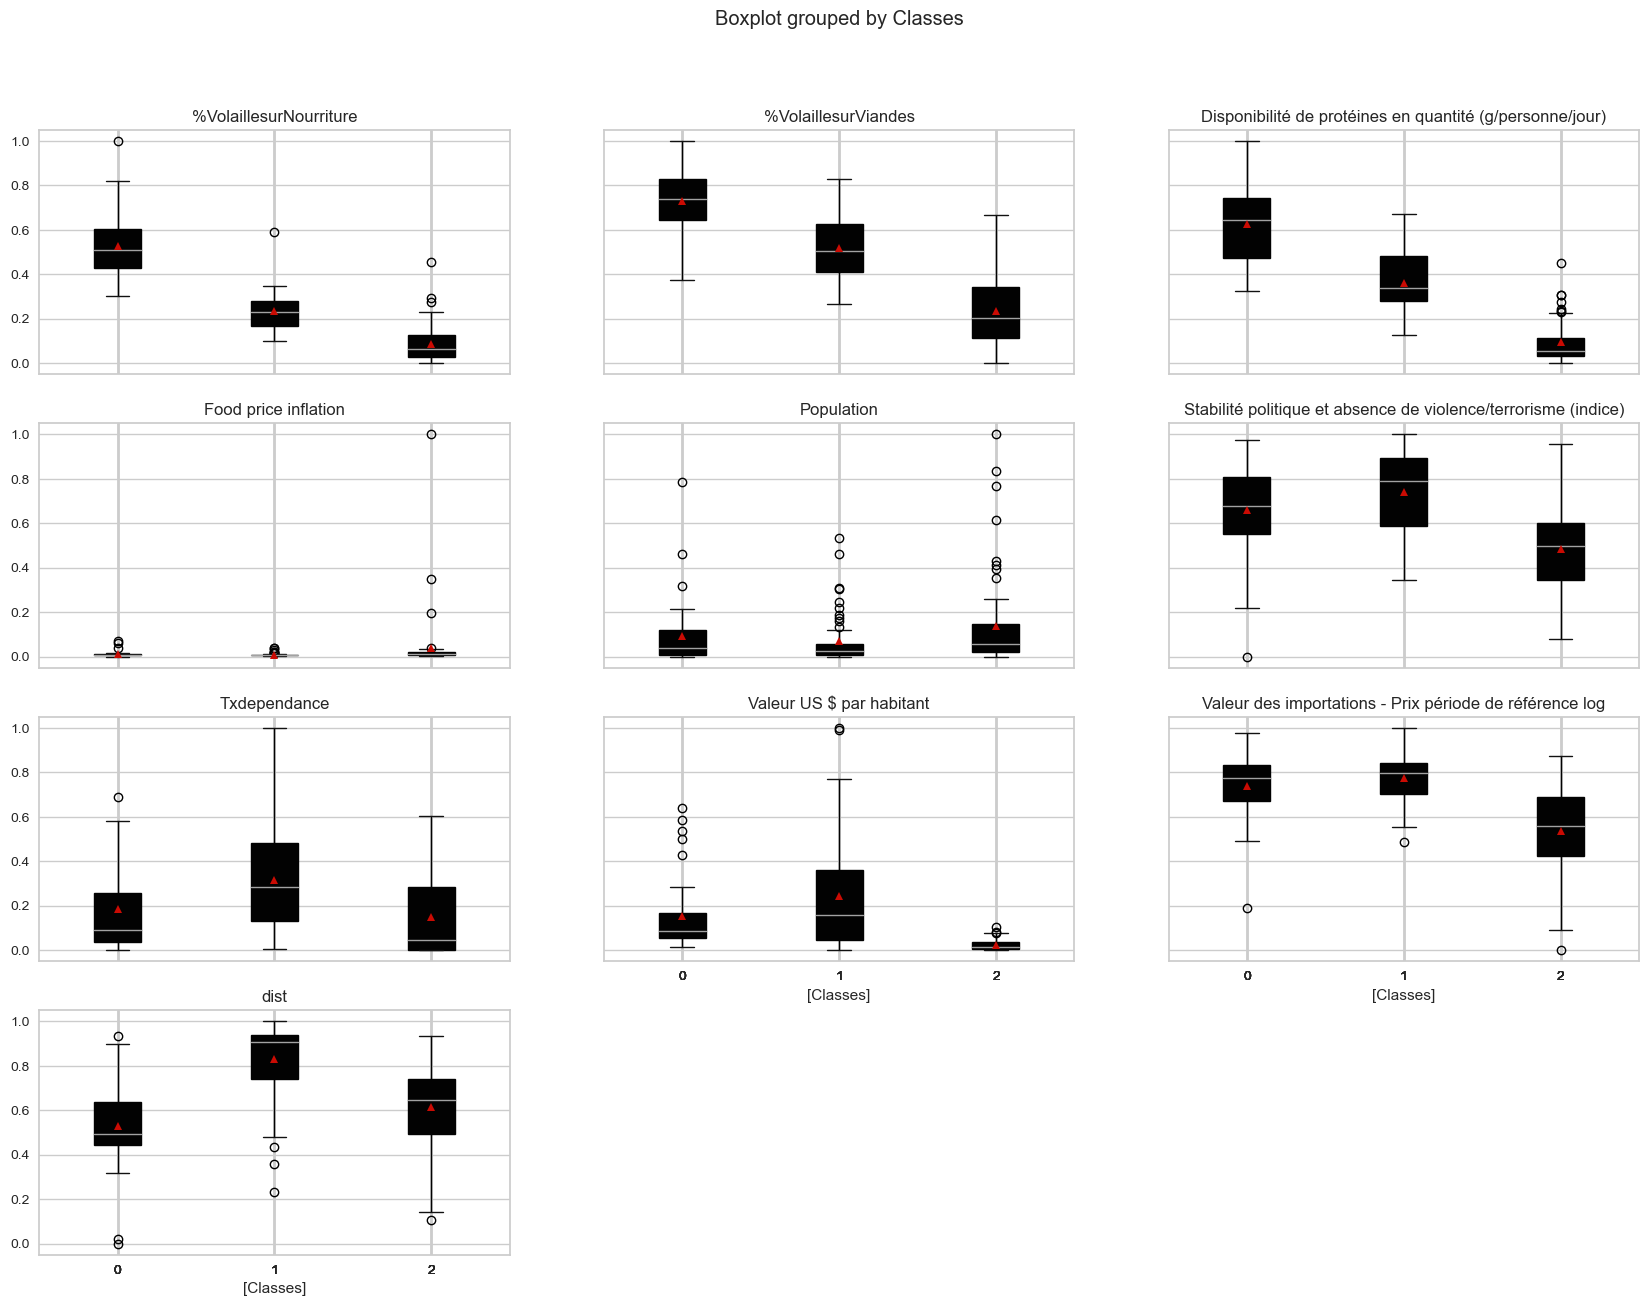

In [33]:
Data_scaled.boxplot(by="Classes", figsize=(20,15), layout=(4,3), patch_artist=True,showmeans=True)
plt.show()

De nombreux outliers sont présents dans pour la variable Food Price Inflation. Cela expliquerai ça mauvaise représentation. Il pourrait être intéressant de supprimer ces outliers. <br>
Concernant la variable Taux de dépendance on remarque que la dispersions est assez similaire entre les clusters 0 et 2. <br> 

# Box plot sur les classes CAH

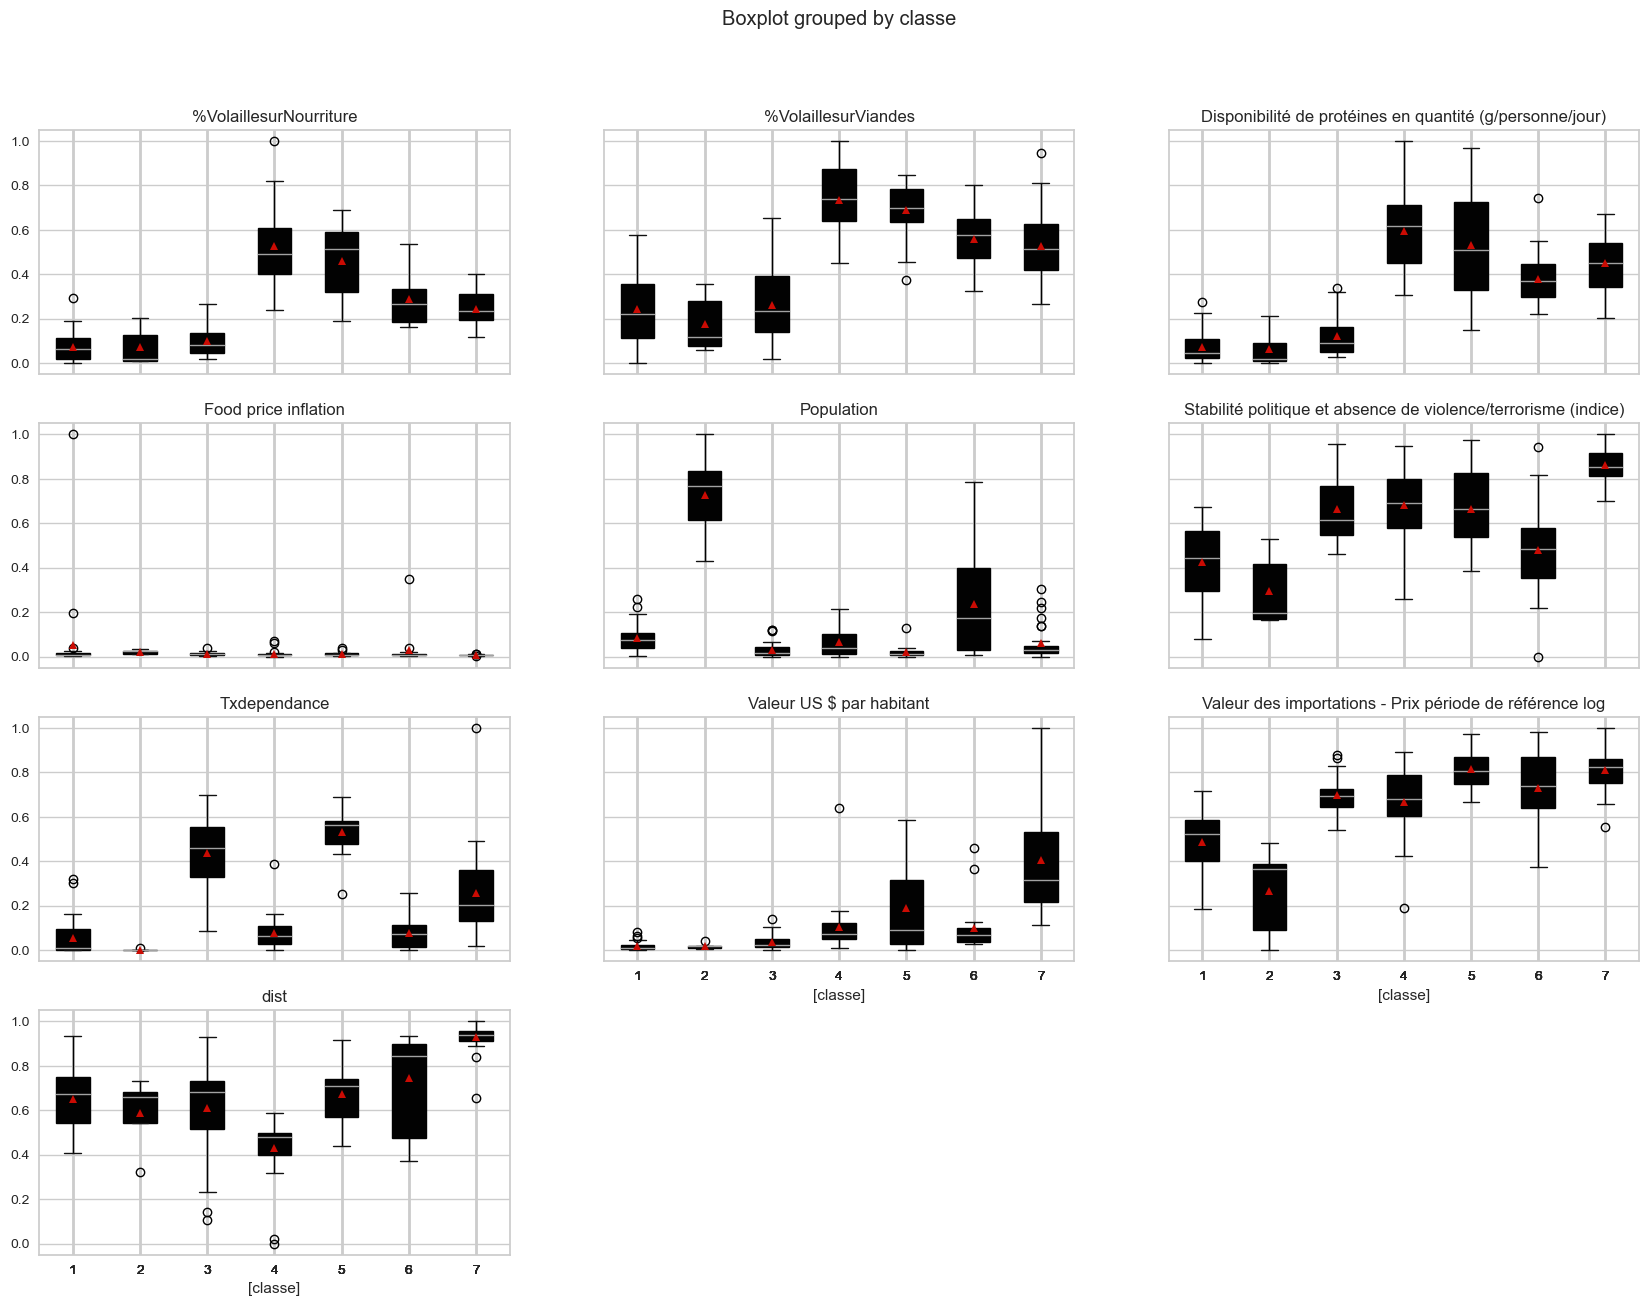

In [34]:
Dendo_classe.boxplot(by="classe", figsize=(20,15), layout=(4,3), patch_artist=True,showmeans=True)
plt.show()

On retrouve bien les mêmes informations que celles vu dans la Heatmap. <br>
Concernant la variable disponibilité en protéine et stabilité politique, on remarque que la dispersions est assez similaire entre les clusters 4 et 5. <br>
Concernant la variable population, c'est le cluster 1 et 4 qui a sa dispersion assez similaire.  <br>
Et enfin, concernant la variable valeur d'importation, le cluster 4 ainsi que le cluster 8 ont une dispersion assez importante comparer au cluster 3.

* [sommaire](#sommaire)

<a class="anchor" id="III.b.5"></a>
<h2 style="text-align: center;text-decoration:bold;color:#736767;background-color:#F2DAEF"> Visualisation sur une carte du monde</h2>


# MapMonde sur clusters de Kmean

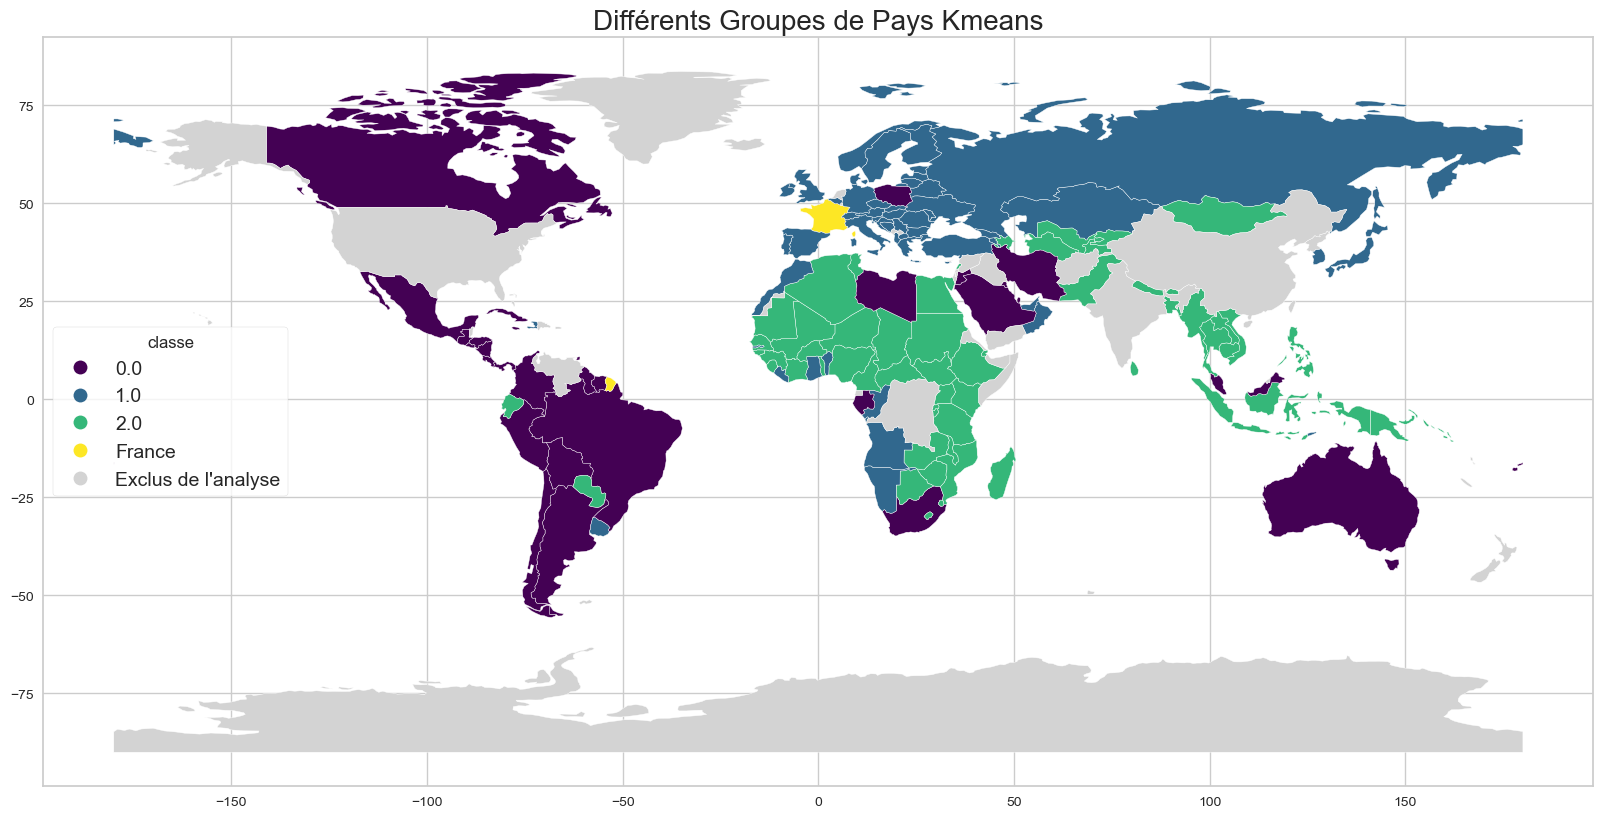

In [35]:
# on fusionne ces deux tableaux et supprime les données dont on n'a pas de besoin
World=pd.merge(world, table_classe.reset_index(), how='left', left_on='name', right_on='Area')
World=World[["pop_est", "continent", "name", "iso_a3", "gdp_md_est","geometry","classe"  ]]
World.loc[World['name']=='France', 'classe']='France'   # on a besoin de marquer la France sur la carte


fig, ax = plt.subplots(figsize=(20, 10))
World.plot(column='classe',
           ax=ax,  
           missing_kwds={"color": "lightgrey", "label": "Exclus de l'analyse"}, # on affiche les valeurs manquantes en gris
           cmap='viridis', 
           legend=True, 
           legend_kwds={'frameon': True, 'loc': 'center left', 'title': 'classe', 'fontsize': 14})
plt.title('Différents Groupes de Pays Kmeans', fontsize=20)
plt.show()

# MapMonde sur clusters de CAH

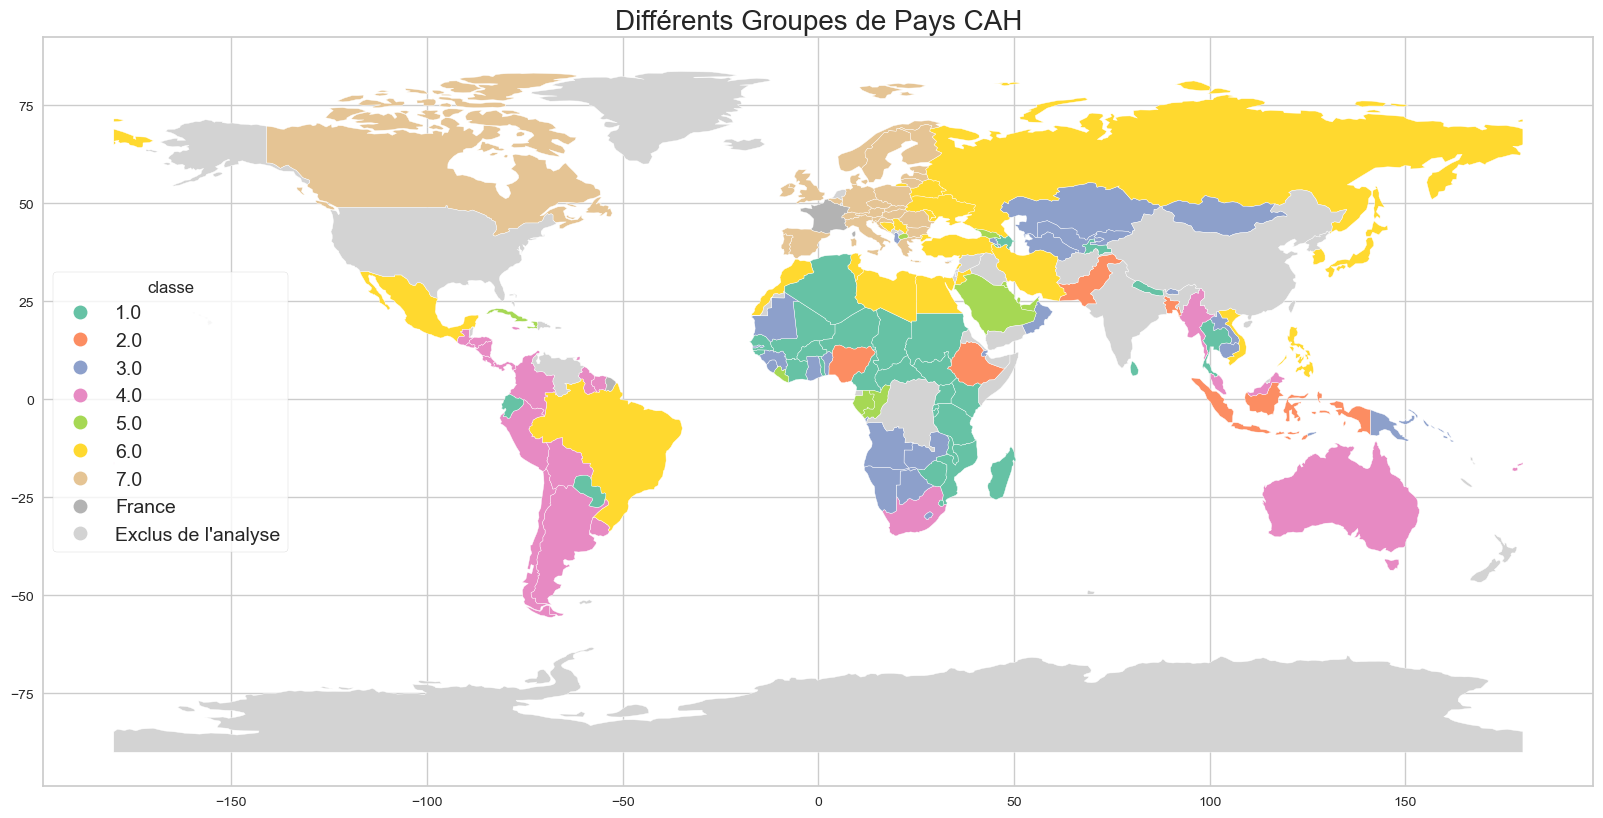

In [36]:
# on fusionne ces deux tableaux et supprime les données dont on n'a pas de besoin
worlds=pd.merge(world, Dendo_classe.reset_index(), how='left', left_on='name', right_on='Area')
worlds=worlds[["pop_est", "continent", "name", "iso_a3", "gdp_md_est","geometry","classe"  ]]
worlds.loc[worlds['name']=='France', 'classe']='France'   # on a besoin de marquer la France sur la carte


fig, ax = plt.subplots(figsize=(20, 10))
worlds.plot(column='classe',
           ax=ax,  
           missing_kwds={"color": "lightgrey", "label": "Exclus de l'analyse"}, # on affiche les valeurs manquantes en gris
           cmap='Set2', 
           legend=True, 
           legend_kwds={'frameon': True, 'loc': 'center left', 'title': 'classe', 'fontsize': 14})
plt.title('Différents Groupes de Pays CAH', fontsize=20)
plt.show()

# Conclusion:   <a class="anchor" id="conclu"></a>


En sélectionnant 10 variables, j'ai identifié des clusters de pays potentiels où nous pourrions développer notre commerce sur les 151 pays. <br> Ces variables sont: <br>
- La Disponibilité de protéines en quantité (g/personne/jour)<br>
    => Pour avoir la quantité de volaille consommée par habitant par jour. <br>
- La proportion de Volaille sur les Viandes <br>
    => Pour connaitre la part de volaille consommée par rapport à tous les types de viandes dans le pays <br>
- La proportion de Volaille sur la Nourriture <br>
    => Pour connaitre la part de volaille consommé par rapport à tous les aliments consommés. Cela permettra de savoir si les pays sont plus végétariens  <br>
- Le taux de dépendance <br>
    => Pour connaitre le taux de dépendance des pays suivant leur consommation de volaille à l'importation depuis l'étranger. <br>
- La Distance <br>
    => Pour connaitre la distance entre le pays et la France. <br>
- La Valeur US par habitant<br>
    => Pour déterminer la richesse par habitant afin de connaitre le potentiel de consommation. <br>
- La Stabilité politique et absence de violence/terrorisme(indice)<br>
    => Pour sélectionner les pays dont le commerce pourrait être pérenne <br>
- La taille de la Population <br>
    => Pour connaitre le nombre de clients que nous pourrions atteindre <br>
- La Valeur des importations <br>
    => Pour connaitre le montant des importations de volaille. <br>
- La proportion d'inflation du pouvoir d'achat depuis 2015<br>
    => Pour connaitre l'évolution du pouvoir d'achat dans la volaille par habitant. <br>



Suivant les moyens et les objectifs de l'entreprise, nous pourrons sélectionner l'un des 3 clusters suivant: <br>
- **Cluster 0 Kmeans**, qui est plutôt axé sur les pays qui sont les plus gros consommateurs de volailles dans le monde avec une assez importante taille de la population. Le potentiel développement de ce groupe est très présent mais ils importent assez peu de volaille de l'étranger et la distance reste très importante. Il serait intéressant d'analyser les coûts de production de volaille dans ces pays afin de déterminer si nous pourrions être plus compétitif en important notre volaille. Il faudra également prendre en compte les coûts de transports afin de s'assurer de la rentabilité de l'exportation. <br>
- **Cluster 1 Kmeans**, qui est plutôt axé sur les pays qui sont fortement dépendant de l'importation de volailles des pays étrangers afin de couvrir leur besoin. Cela signifie qu'ils sont très ouvert au commerce international. Ces pays ayant une certaines proximité avec la France et une certaine richesse, le potentiel est très présent. Cependant, la concurrence risque d'y être très présente également. Il faudra donc analyser la concurrence afin de déterminer le taux de saturation du marché et si nous sommes compétitif par rapport aux autres pays exportateurs de volailles.   <br>
- **Cluster 4 et 5 de la Classification ascendante hiérarchique**, qui ont des profils de pays assez similaires au cluster 0 et 1 Kmeans réunis. Nous pourrions aussi les prendre séparément si nous devons limiter les études de marchés à un plus faible nombre de pays à cibler. Le Cluster 4 CAH se rapproche du profil du cluster 0 Kmeans et le Cluster 5 CAH se rapproche du profil du cluster 1 Kmeans. <br> 


Le choix final de pays sera donc fait en fonction de la stratégie établie par l'entreprise sur son développement commercial à l'international. 

* [sommaire](#sommaire)